# Introduction

In [8]:
# @title packages and versions

# common packages
import os
from typing import Callable, List, Tuple
from tqdm import notebook

import torch
print(f"{torch.__version__=}")
from torch import nn
from torch.nn import functional
from torch import optim
from torch.nn.modules import loss
from torch.utils import data

import torchvision
print(f"{torchvision.__version__=}")
from torchvision import datasets
from torchvision import transforms

print(f"{torch.cuda.is_available()=}")
if torch.cuda.is_available():
    print(f"{torch.cuda.device_count()=}")
    for i in range(torch.cuda.device_count()):
        print(f"{torch.cuda.get_device_name(i)=}")
        print(f"{torch.cuda.get_device_capability(i)=}")
        print(f"{torch.cuda.get_device_properties(i)=}")
print(f"{torch.get_num_threads()=}")


# other packages
from PIL import Image
import numpy
import matplotlib.pyplot as plt
import matplotlib.animation as animation

torch.__version__='2.5.1+cu124'
torchvision.__version__='0.20.1+cu124'
torch.cuda.is_available()=True
torch.cuda.device_count()=1
torch.cuda.get_device_name(i)='NVIDIA GeForce GTX 1650'
torch.cuda.get_device_capability(i)=(7, 5)
torch.cuda.get_device_properties(i)=_CudaDeviceProperties(name='NVIDIA GeForce GTX 1650', major=7, minor=5, total_memory=3896MB, multi_processor_count=14, uuid=560e41e1-6e4e-a484-4b92-7d92ebc90683, L2_cache_size=1MB)
torch.get_num_threads()=4


In [9]:
# @title variables
data_path = 'data'
contents_path = os.path.join(data_path, '.contents')
models_path = os.path.join(data_path, 'models')
out_path = os.path.join(data_path, 'out')
mnist_contents = os.path.join(contents_path, 'MNIST')
mnist_models = os.path.join(models_path, 'MNIST')

# download data
datasets.MNIST(mnist_contents, train=True, download=True)
datasets.MNIST(mnist_contents, train=False, download=True)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data/.contents/MNIST
    Split: Test

# Definitions

In [10]:
# @title DeepHNN

class DeepHNN(nn.Module):

    channels: int
    features: int
    neurons: int
    deep: int
    iterations: int

    _logbeta: nn.Parameter
    _bias: nn.Parameter
    _patterns: nn.Parameter

    def __init__(
            self,
            channels: int,
            features: int,
            deep: int,
            neurons: int,
            iterations: int = 1,
            beta_trainable: bool = True,
            bias_trainable: bool = True,
            patterns_trainable: bool = True,
        ) -> None:

        super(DeepHNN, self).__init__()

        assert channels > 0, "channels must be greater than 0"
        assert features > 0, "features must be greater than 0"
        assert deep > 0, "deep must be greater than 0"
        assert neurons > 0, "neurons must be greater than 0"
        assert iterations >= 0, "number of iterations must be greater than or equal to 0"

        self.channels = channels
        self.features = features
        self.deep = deep
        self.neurons = neurons
        self.iterations = iterations

        if beta_trainable:
            self._logbeta = nn.Parameter(torch.zeros(channels), requires_grad=beta_trainable)
        else:
            self._logbeta = nn.Parameter(torch.zeros(channels), requires_grad=beta_trainable)
        self._patterns = nn.Parameter(torch.tanh(torch.randn(channels, deep*features, neurons)), requires_grad=patterns_trainable)
        if bias_trainable:
            self._bias = nn.Parameter(torch.randn(channels, features), requires_grad=bias_trainable)
        else:
            self._bias = nn.Parameter(torch.zeros(channels, features), requires_grad=bias_trainable)

    def update_patterns(self, patterns: torch.Tensor, trainable: bool|None=None) -> None:
        
        assert patterns.shape == self._patterns.data.shape, "shape of patterns must be the same as the current patterns"

        _trainable: bool
        if trainable is None:
            _trainable = self._patterns.requires_grad

        self._patterns = nn.Parameter(
            patterns.clone().detach().requires_grad_(_trainable),
            requires_grad=_trainable
        )

    def update_beta(self, beta: torch.Tensor, trainable: bool|None=None) -> None:

        assert beta.shape == self._logbeta.data.shape, "shape of beta must be the same as the current beta"
        assert torch.all(beta > 0), "all elements of beta must be greater than 0"

        _trainable: bool
        if trainable is None:
            _trainable = self._logbeta.requires_grad

        self._logbeta = nn.Parameter(
            torch.log(beta).clone().detach().to(self._logbeta.device).requires_grad_(_trainable),
            requires_grad=_trainable
        )

    def update_bias(self, bias: torch.Tensor, trainable: bool|None=None) -> None:

        assert bias.shape == self._bias.data.shape, "shape of bias must be the same as the current bias"

        _trainable: bool
        if trainable is None:
            _trainable = self._bias.requires_grad

        self._bias = nn.Parameter(
            torch.log(bias).clone().detach().to(self._bias).requires_grad_(_trainable),
            requires_grad=_trainable
        )

    def get_patterns(self) -> torch.Tensor:
        return self._patterns.clone().detach().view(self.channels, self.features, self.deep, self.neurons)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # Shape of x must be (batch, channels, neurons)
    
        L = torch.exp(self._logbeta).view(self.channels, 1, 1) * self._patterns
        A = torch.einsum('cin , cjn-> cij', L, self._patterns)  # i,j are logits
        
        # main algorithm
        x = torch.einsum('cln, bcn -> bcl', L, x)  # get logits
        for _ in range(self.iterations):
            x = functional.softmax(x, dim=2)  # get probs
            x = torch.einsum('clp, bcp -> bcl', A, x)  # get logits
        
        # max reduction
        x = x.view(-1, self.channels, self.features, self.deep)
        x = torch.max(x, dim=3).values
        x = x + self._bias.view(1, self.channels, self.features)
        
        return x

In [11]:
# @title ConvHNN2d
class ConvHNN2d(nn.Module):

    channels_in: int
    channels_out: int
    kernel_size: Tuple[int, int]
    padding: Tuple[int, int]
    stride: Tuple[int, int]
    dilation: Tuple[int, int]

    iterations: int

    _logbeta: nn.Parameter
    _bias: nn.Parameter
    _patterns: nn.Parameter

    def __init__(
            self,
            channels_in: int,
            channels_out: int,
            kernel_size: Tuple[int, int],
            padding: Tuple[int, int] = (0, 0),
            stride: Tuple[int, int] = (1, 1),
            dilation: Tuple[int, int] = (1, 1),
            iterations: int = 1,
            beta_trainable: bool = True,
            patterns_trainable: bool = True,
            bias_trainable: bool = True,
        ) -> None:
        super(ConvHNN2d, self).__init__()

        assert channels_in > 0
        assert channels_out > 0
        assert kernel_size[0] > 0
        assert kernel_size[1] > 0
        assert padding[0] >= 0
        assert padding[1] >= 0
        assert stride[0] > 0
        assert stride[1] > 0
        assert dilation[0] > 0
        assert dilation[1] > 0
        assert iterations > 0

        self.channels_in = channels_in
        self.channels_out = channels_out
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.dilation = dilation
        self.iterations = iterations

        if beta_trainable:
            self._logbeta = nn.Parameter(torch.randn((1,)), requires_grad=beta_trainable)
        else:
            self._logbeta = nn.Parameter(torch.zeros((1,)), requires_grad=beta_trainable)
        self._patterns = nn.Parameter(torch.tanh(torch.randn(channels_out, channels_in, kernel_size[0], kernel_size[1])), requires_grad=patterns_trainable)
        if bias_trainable:
            self._bias = nn.Parameter(torch.randn(channels_out,), requires_grad=bias_trainable)
        else:
            self._bias = nn.Parameter(torch.zeros(channels_out,), requires_grad=bias_trainable)

    def update_patterns(self, patterns: torch.Tensor, trainable: bool|None=None) -> None:
        assert patterns.shape == self._patterns.data.shape

        _trainable: bool
        if trainable is None:
            _trainable = self._patterns.requires_grad

        self._patterns = nn.Parameter(
            patterns.clone().detach().to(self._patterns.device).requires_grad_(_trainable),
            requires_grad=_trainable)

    def update_beta(self, beta: float, trainable: bool|None=None) -> None:
        assert beta > 0

        _trainable: bool
        if trainable is None:
            _trainable = self._logbeta.requires_grad

        self._logbeta.data = nn.Parameter(
            torch.log(torch.tensor(beta)).clone().detach().to(self._logbeta.device).requires_grad_(_trainable),
            requires_grad=_trainable)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # Shape of x must be (batch, channels_in, #, #)
        
        weight_loop = (
            torch.exp(self._logbeta)
            * torch.einsum(
                'in, jn -> ij',  # i,j are logits (channels_out)
                self._patterns.view(self.channels_out, -1),
                self._patterns.view(self.channels_out, -1)
            )
        ).view(self.channels_out, self.channels_out, 1, 1)

        x = nn.functional.conv2d(
            x,
            torch.exp(self._logbeta) * self._patterns,
            stride=self.stride,
            padding=self.padding,
            dilation=self.dilation,
        )
        for _ in range(self.iterations):
            x = nn.functional.softmax(x, dim=1)
            x = nn.functional.conv2d(x, weight_loop)

        return x + self._bias.view(1,self.channels_out,1,1)

In [12]:
# @title VHNN

class VHNN(nn.Module):

    channels : int
    features : int
    neurons : int

    iterations : int

    _logbeta : nn.Parameter
    _lognoise : nn.Parameter
    _patterns : nn.Parameter

    def __init__(
            self,
            channels: int,
            features: int,
            neurons: int,
            iterations: int = 1,
            beta_trainable: bool = True,
            patterns_trainable: bool = True,
            noise_trainable: bool = True,
        ) -> None:
        super(VHNN, self).__init__()

        assert channels > 0
        assert features > 0
        assert neurons > 0
        assert iterations > 0

        self.channels = channels
        self.features = features
        self.neurons = neurons
        self.iterations = iterations

        if beta_trainable:
            self._logbeta = nn.Parameter(torch.zeros(channels), requires_grad=beta_trainable)
        else:
            self._logbeta = nn.Parameter(torch.zeros(channels), requires_grad=beta_trainable)
        self._patterns = nn.Parameter(torch.tanh(torch.randn(channels, features, neurons)), requires_grad=patterns_trainable)
        if noise_trainable:
            self._lognoise = nn.Parameter(torch.randn((channels,))-3, requires_grad=noise_trainable)
        else:
            self._lognoise = nn.Parameter(torch.zeros((channels,))-3, requires_grad=noise_trainable)

    def update_patterns(self, patterns: torch.Tensor, trainable: bool|None=None) -> None:
        
        assert patterns.shape == self._patterns.data.shape, "shape of patterns must be the same as the current patterns"

        _trainable: bool
        if trainable is None:
            _trainable = self._patterns.requires_grad

        self._patterns = nn.Parameter(
            patterns.clone().detach().requires_grad_(_trainable),
            requires_grad=_trainable
        )

    def update_beta(self, beta: torch.Tensor, trainable: bool|None=None) -> None:

        assert beta.shape == self._logbeta.data.shape, "shape of beta must be the same as the current beta"
        assert torch.all(beta > 0), "all elements of beta must be greater than 0"

        _trainable: bool
        if trainable is None:
            _trainable = self._logbeta.requires_grad

        self._logbeta = nn.Parameter(
            torch.log(beta).clone().detach().to(self._logbeta.device).requires_grad_(_trainable),
            requires_grad=_trainable
        )

    def update_noise(self, noise: torch.Tensor, trainable: bool|None=None) -> None:

        assert noise.shape == self._lognoise.data.shape, "shape of noise must be the same as the current noise"

        _trainable: bool
        if trainable is None:
            _trainable = self._lognoise.requires_grad

        self._lognoise = nn.Parameter(
            torch.log(noise).clone().detach().to(self._lognoise).requires_grad_(_trainable),
            requires_grad=_trainable
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = x.view(-1, self.channels, self.neurons)

        L = torch.exp(self._logbeta/2).view(-1, 1, 1) * self._patterns

        x = torch.exp(self._logbeta/2).view(1, -1, 1) * x
        for _ in range(self.iterations):
            x = torch.einsum('cfn, bcn -> bcf', L, x)
            x = nn.functional.softmax(x, dim=2)
            epsilon = torch.randn_like(x, device=x.device, requires_grad=False)
            xdet = x.detach().requires_grad(False)
            x = x + torch.exp(self._lognoise).view(1,-1,1) * (xdet*(1-xdet))**0.5 * epsilon
            x = torch.einsum('cfn, bcf -> bcn', L, x)

        x = torch.exp(-self._logbeta/2).view(1, -1, 1) * x
        return x

In [17]:
# @title ConvexMerge

class ConvexMerge(nn.Module):

    _weights: nn.Parameter  # weights
    channels: int  # number of input channels
    classes: int  # number of classes
    features_out: int  # number of output features
    features_in: int  # number of input features


    def __init__(self, channels: int, classes: int, features_out: int, features_in: int) -> None:
        super(ConvexMerge, self).__init__()

        assert channels > 0
        assert classes > 0
        assert features_out > 0
        assert features_in > 0

        self._weights = nn.Parameter(torch.randn(channels, classes, features_out, features_in))

        self.channels = channels
        self.classes = classes
        self.features_out = features_out
        self.features_in = features_in

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = x.view(x.shape[0], self.channels, self.classes, self.features_in)

        return torch.einsum('kcoi, bkci -> bkco', nn.functional.softmax(self._weights, dim=-1), x)

In [18]:
# @title trainer_classification
def trainer_classification(
        model: nn.Module,
        data_loader: data.DataLoader,
        loss_fn: callable,
        reg_fn: callable,
        optimizer,
        n_epochs: int,
        input_converter: None|Callable[[torch.Tensor], torch.Tensor] = None,
        output_converter: None|Callable[[torch.Tensor], torch.Tensor] = None,
        device: torch.device = torch.device("cpu")
    ) -> Tuple[List[float], List[float], List[float]]:
    torch.cuda.empty_cache()
    model.to(device)
    model.train()

    accuracy : List[float] = []
    loss : List[float] = []
    reg : List[float] = []
    total : List[float] = []

    progressBar_epoch = notebook.tqdm(
        range(n_epochs),
        desc="Epochs",
        leave=False)
    for _ in progressBar_epoch:


        x: torch.Tensor
        y: torch.Tensor

        accuracy_epoch = 0.0
        loss_epoch = 0.0
        reg_epoch = 0.0
        total_epoch = 0.0

        progressBar_batch = notebook.tqdm(
            data_loader,
            desc="Batches",
            total=len(data_loader),
            leave=False)
        for x, y in progressBar_batch:

            x, y = x.to(device), y.to(device)

            if input_converter != None:
                x = input_converter(x)
            if output_converter != None:
                y = output_converter(y)

            optimizer.zero_grad()
            _y = model(x)
            accuracy_batch = torch.count_nonzero(torch.argmax(_y, dim=1) == y) / y.shape[0]
            batch_reg: torch.Tensor = reg_fn(model)
            batch_loss: torch.Tensor = loss_fn(_y, y)
            batch_total: torch.Tensor = batch_loss + batch_reg

            batch_total.backward()
            optimizer.step()

            accuracy_epoch += accuracy_batch.item()
            loss_epoch += batch_loss.item()
            reg_epoch += batch_reg.item()
            total_epoch += batch_reg.item()+batch_loss.item()

        accuracy.append(accuracy_epoch / len(data_loader))
        loss.append(loss_epoch / len(data_loader))
        reg.append(reg_epoch / len(data_loader))
        total.append(total_epoch / len(data_loader))

        progressBar_epoch.set_postfix(
            loss= loss[-1],
            reg= reg[-1],
            accuracy= accuracy[-1],
        )

    return accuracy, loss, reg, total

In [19]:
# @title trainer_autoencoder

def trainer_autoencoder(
        model: nn.Module,
        data_loader: data.DataLoader,
        loss_fn: callable,
        reg_fn: callable,
        optimizer,
        n_epochs: int,
        input_converter: None|Callable[[torch.Tensor], torch.Tensor] = None,
        output_converter: None|Callable[[torch.Tensor], torch.Tensor] = None,
        device: torch.device = torch.device("cpu")
    ) -> Tuple[List[float], List[float], List[float]]:
    torch.cuda.empty_cache()
    model.to(device)
    model.train()

    loss : List[float] = []
    reg : List[float] = []
    total : List[float] = []

    progressBar_epoch = notebook.tqdm(
        range(n_epochs),
        desc="Epochs",
        leave=False)
    for _ in progressBar_epoch:

        x: torch.Tensor

        loss_epoch = 0.0
        reg_epoch = 0.0
        total_epoch = 0.0

        progressBar_batch = notebook.tqdm(
            data_loader,
            desc="Batches",
            total=len(data_loader),
            leave=False)
        for x, _ in progressBar_batch:

            x = x.to(device)

            y = x.clone()
            if input_converter != None:
                x = input_converter(x)
            if output_converter != None:
                y = output_converter(y)

            optimizer.zero_grad()
            _y = model(x)
            batch_reg: torch.Tensor = reg_fn(model)
            batch_loss: torch.Tensor = loss_fn(_y, y)
            batch_total: torch.Tensor = batch_loss + batch_reg

            batch_total.backward()
            optimizer.step()

            loss_epoch += batch_loss.item()
            reg_epoch += batch_reg.item()
            total_epoch += batch_reg.item()+batch_loss.item()

        loss.append(loss_epoch / len(data_loader))
        reg.append(reg_epoch / len(data_loader))
        total.append(total_epoch / len(data_loader))

        progressBar_epoch.set_postfix(
            loss= loss[-1],
            reg= reg[-1],
        )

    return loss, reg, total

In [20]:
# @title tester_classification
def tester_classification(model: nn.Module, data_loader: data.DataLoader, device: torch.device) -> float:
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():

        x: torch.Tensor
        y: torch.Tensor

        for x, y in notebook.tqdm(data_loader, desc="Batches", leave=False):
            x, y = x.to(device), y.to(device)
            _y = model(x)
            _, predicted = torch.max(_y, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    return correct / total

In [21]:
# @title tester_autoencoder

def tester_autoencoder(
        model: nn.Module,
        data_loader: data.DataLoader,
        device: torch.device,
        input_converter: None|Callable[[torch.Tensor], torch.Tensor] = None,
        output_converter: None|Callable[[torch.Tensor], torch.Tensor] = None,
    ) -> float:
    model.to(device)
    model.eval()

    total = 0.0

    with torch.no_grad():

        x: torch.Tensor

        for x, _ in notebook.tqdm(data_loader, desc="Batches", leave=False):

            x = x.to(device)
            y = x.clone()
            if input_converter != None:
                x = input_converter(x)
            if output_converter != None:
                y = output_converter(y)

            _y = model(x)
            loss = nn.functional.mse_loss(_y, y, reduction='mean')
            total += loss.item()

    return total / len(data_loader)

# MNIST

In [44]:
# @title Used transform

transform=transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.RandomAffine(
            degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10
        ),
        transforms.ColorJitter(contrast=(0.9, 1.5)),
        transforms.Pad(2),  # pad to 32x32
    ]
)

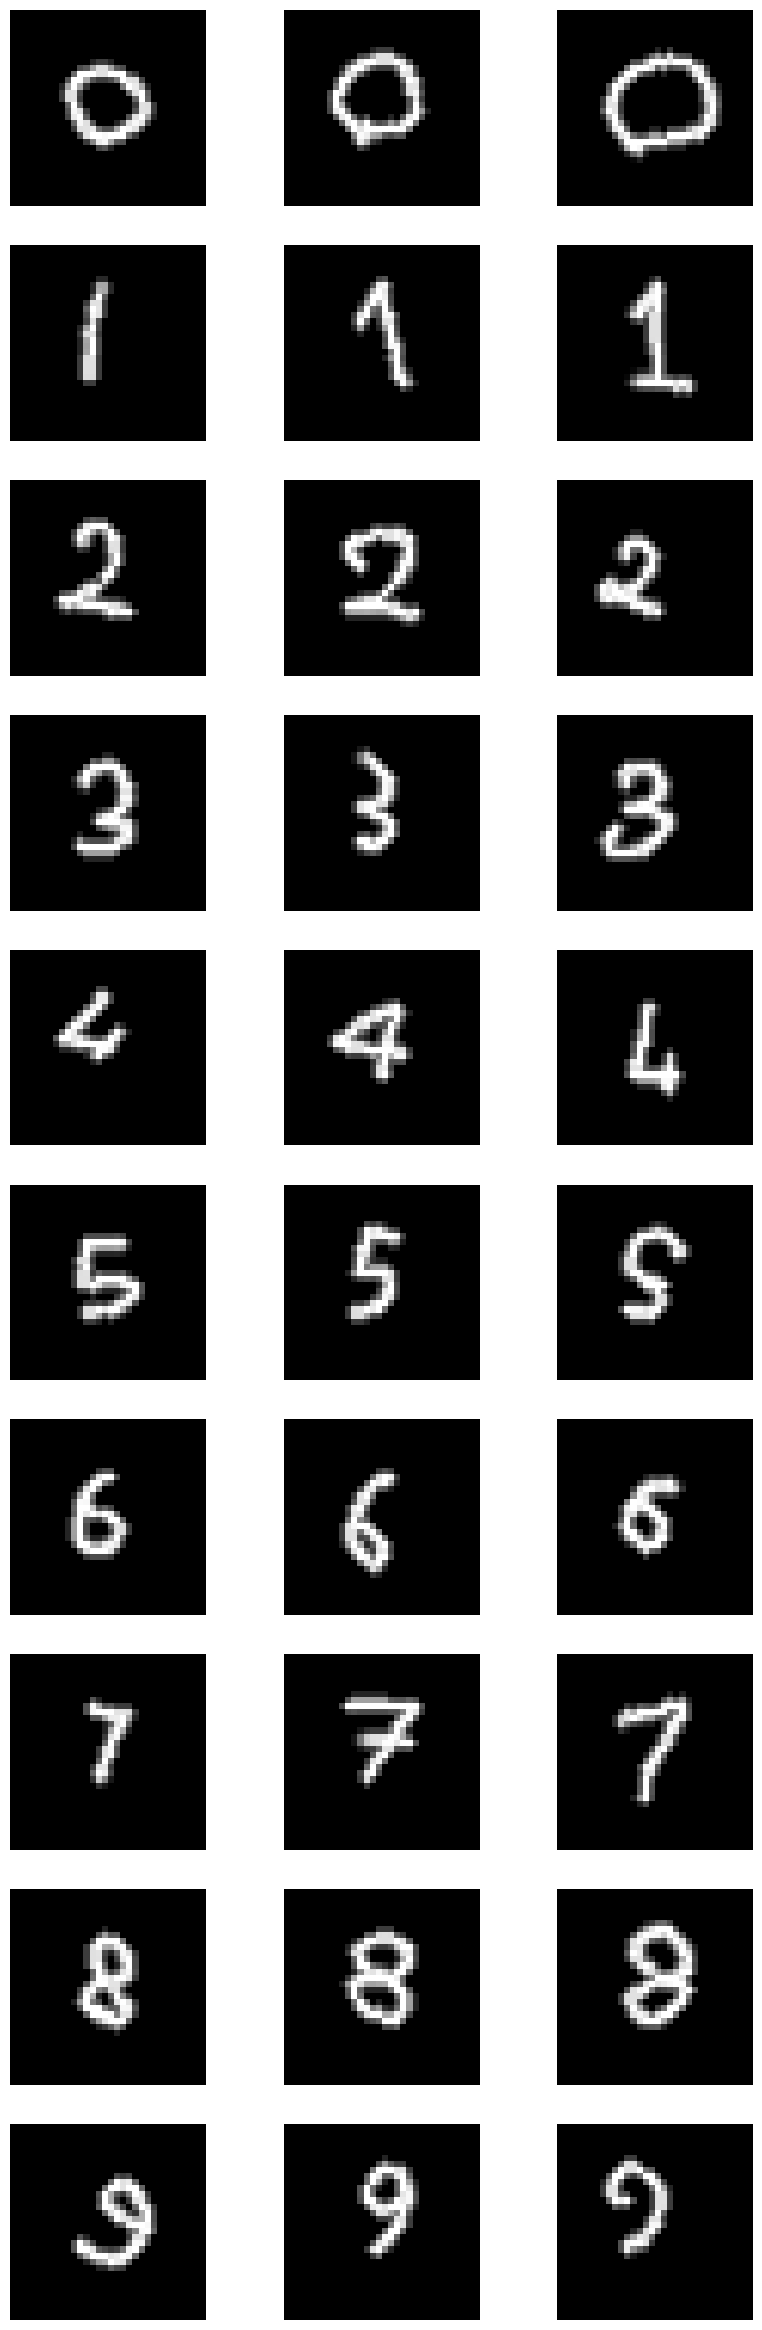

In [45]:
# @title Load patterns
patterns = torch.empty(30, 32, 32)
for i in range(10):
    for j in range(3):
        img = Image.open(f"{mnist_models}/pattern{i}_{j}.png").convert('L')
        npimg = numpy.array(img)
        patterns[i*3+j] = torch.tensor(npimg)

patterns = patterns.unsqueeze(1).float() / 255.0
patterns = 2.0 * patterns - 1.0

# show patterns
fig, axs = plt.subplots(10, 3, figsize=(10, 30))
for i in range(10):
    for j in range(3):
        axs[i, j].imshow(patterns[i*3+j,0], cmap='gray', vmin=-1, vmax=1)
        axs[i, j].axis('off')
plt.show()

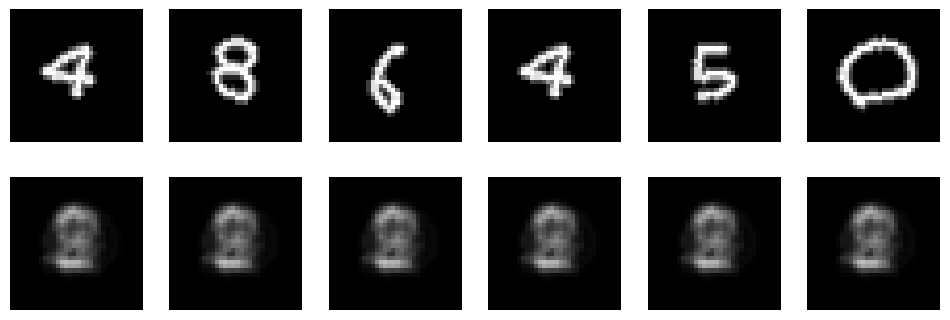

In [ ]:
# @title Testing Hopfield using patterns
model = [
    DeepHNN(1, 30, 1, 32*32, iterations=1, beta_trainable=False, patterns_trainable=False)
    for _ in range(1)
]
for m in model:
    m.update_patterns(patterns.view(1, 30, -1))
    m.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

model[0].update_beta(torch.ones(1)*0.0001)

test_set = datasets.MNIST(mnist_contents, train=False, download=False, transform=transform)
data_loader = data.DataLoader(test_set, batch_size=1, shuffle=True)

# get a batch of images
x = patterns[torch.randint(0, 30, (6,))].clone().detach().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

fig, axs = plt.subplots(2, 6, figsize=(6*2, 2*2))
for i in range(2):
    for j in range(6):
        img = x[j].clone().detach().to(x.device)
        axs[i, j].imshow(img[0].cpu().detach().numpy(), cmap='gray', vmin=-1, vmax=1)
        axs[i, j].axis('off')
    x = x.view(6, 1, -1)
    x = model[0](x)
    x = functional.softmax(x, dim=2)
    x = torch.einsum('bcl, cln -> bcn', x, model[0]._patterns)
    x = x.view(6, 1, 32, 32)
plt.show()

## Simple experiment

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

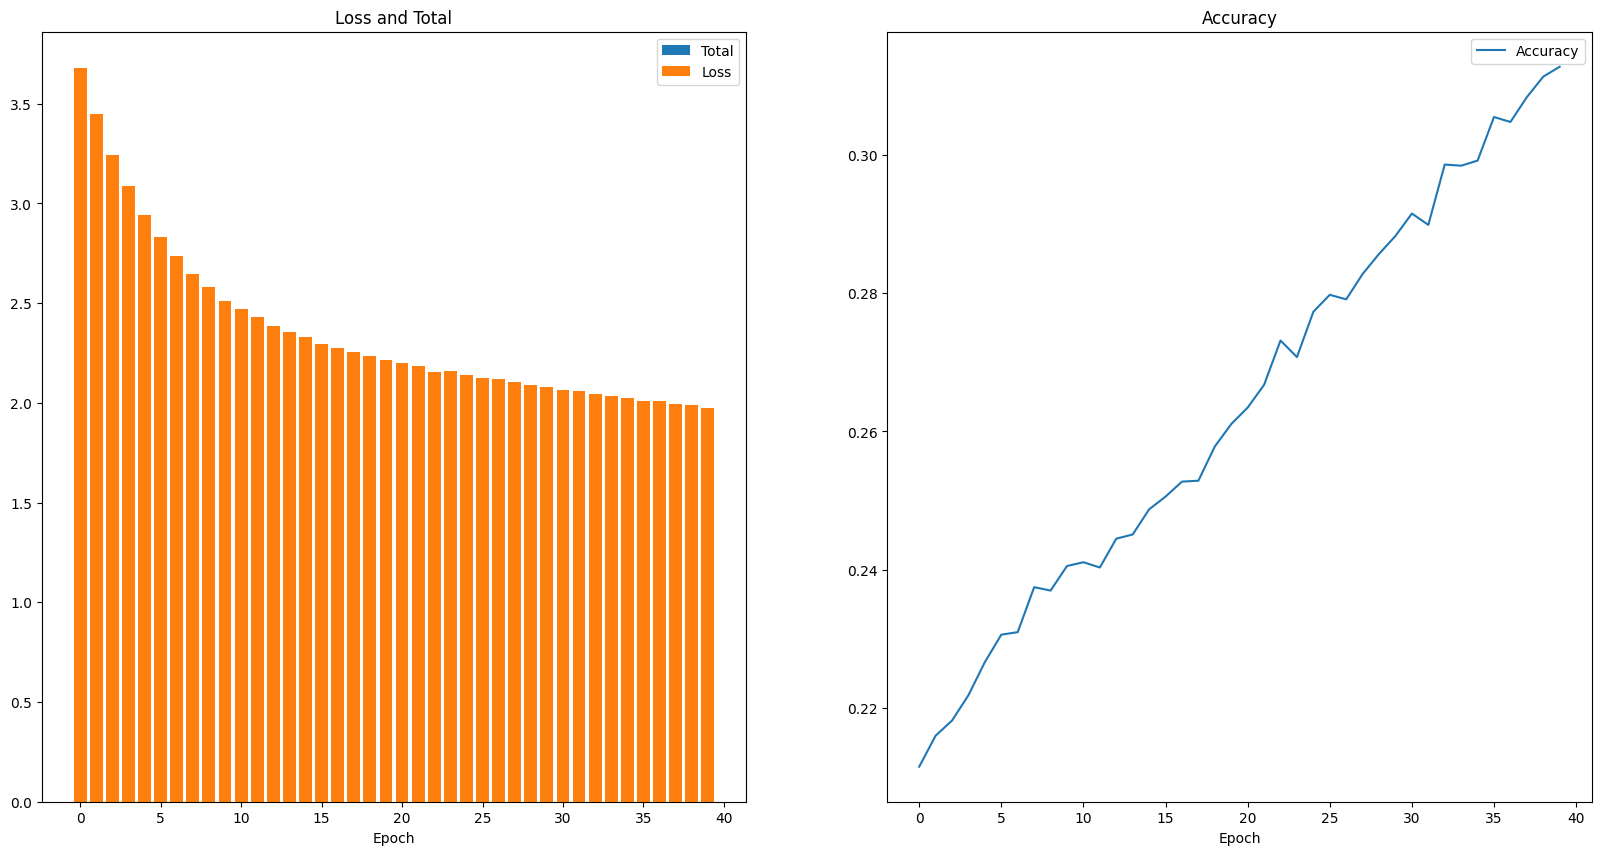

In [ ]:
# @title training
train_set = datasets.MNIST(mnist_contents, train=True, download=False, transform=transform)
train_loader = data.DataLoader(train_set, batch_size=16_384, shuffle=True)

class MyModel(nn.Module):

    def __init__(self):
        super(MyModel, self).__init__()
        self.Hopfield = DeepHNN(1, 10, 3, 32*32, iterations=1, beta_trainable=False)

        self.Hopfield.update_patterns(patterns.view(1, 30, -1))
        self.Hopfield.update_beta(torch.ones(1)*0.07)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.shape[0], 1, -1)
        x = nn.BatchNorm1d(1, affine=False).to(x.device)(x)
        x = self.Hopfield(x)
        x = x.view(x.shape[0], -1)
        return x

model = MyModel()

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters())

# (ignorable function)
def reg_fn(model: MyModel) -> torch.Tensor:
    return torch.tensor(0.0)

accuracy, loss, reg, total = trainer_classification(
    model,
    train_loader,
    loss_fn,
    reg_fn,
    optimizer,
    40,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].bar(range(len(total)), total, label="Total")
axs[0].bar(range(len(loss)), loss, label="Loss")
axs[0].legend()
axs[0].set_title("Loss and Total")
axs[0].set_xlabel("Epoch")
axs[1].plot(range(len(accuracy)), accuracy, label="Accuracy")
axs[1].legend()
axs[1].set_title("Accuracy")
axs[1].set_xlabel("Epoch")
plt.savefig(f"{out_path}/MNIST_SimpleExperiment.png", dpi=300)

In [28]:
# @title testing
test_set = datasets.MNIST(mnist_contents, train=False, download=False, transform=transform)
test_loader = data.DataLoader(test_set, batch_size=16_384, shuffle=False)

tester_classification(model, test_loader, torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.3164

 beta = tensor([0.0700])
 bias = tensor([-0.0472, -0.6809,  0.8763,  0.2130,  0.8340, -1.0671, -0.9793,  0.5041,
         1.3488,  0.1904])


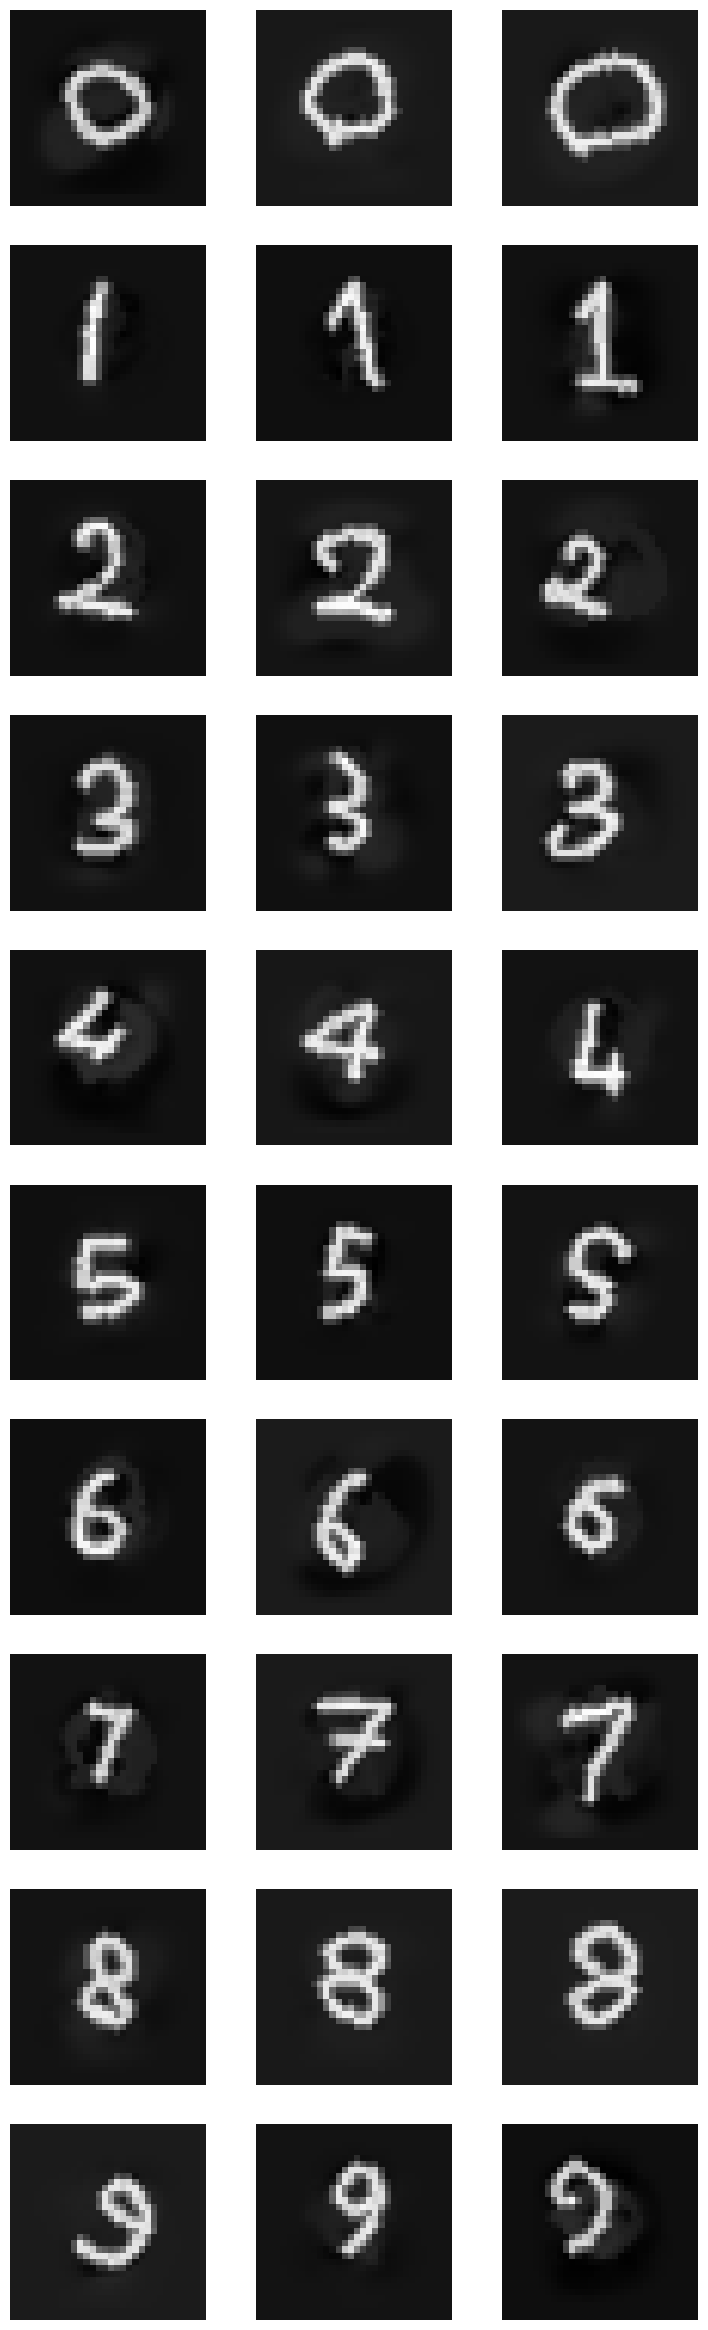

In [ ]:
# @title analysis
model.to(torch.device("cpu"))

print(f" beta = {torch.exp(model.Hopfield._logbeta.data)}")
print(f" bias = {model.Hopfield._bias.data.view(10,)}")

found_patterns = model.Hopfield._patterns.data.view(10, 3, 32, 32).clone().to('cpu').numpy()

fig, axs = plt.subplots(10, 3, figsize=(3*3, 10*3))

for i in range(10):
    for j in range(3):
        axs[i, j].imshow(found_patterns[i][j], cmap='gray', vmin=found_patterns.min(), vmax=found_patterns.max())
        axs[i, j].axis('off')

plt.savefig(f"{out_path}/MNIST_patterns.png", dpi=300)

## Hopfield as MLP

trainable parameters: 56440


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

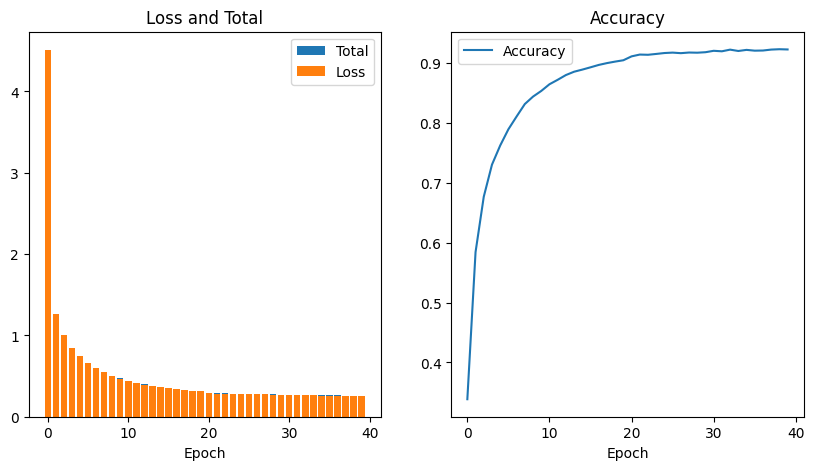

In [ ]:
# @title training
train_set = datasets.MNIST(mnist_contents, train=True, download=False, transform=transform)
train_loader = data.DataLoader(train_set, batch_size=1_024, shuffle=True)

channels = 5
deep = 5
features = 10

class MyModel(nn.Module):

    def __init__(self):
        super(MyModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, channels, 4, stride=2),
        )
        self.Hopfield = nn.Sequential(
            nn.BatchNorm1d(channels, affine=False),
            DeepHNN(channels, features, deep, 15*15, iterations=1),
        )
        self.merge = ConvexMerge(1, features, 1, channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.cnn(x)
        x = x.view(x.shape[0], channels, -1)
        x = self.Hopfield(x)
        x = x.transpose(1, 2).view(x.shape[0],1,features,channels)
        x = self.merge(x)
        x = x.view(x.shape[0], features)
        return x

model = MyModel()

print(f"trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

loss_fn = nn.CrossEntropyLoss()

def reg_fn(model: MyModel) -> torch.Tensor:
    reg = torch.tensor(0.0).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    for p in model.cnn.parameters():
        reg += torch.mean(torch.abs(p))

    reg += torch.max(torch.mean(model.merge._weights, dim=1)**2)
    return 0.01*reg

accuracy: List[float] = []
loss: List[float] = []
reg: List[float] = []
total: List[float] = []

optimizer = optim.Adam(model.parameters(), lr=0.01)

a, l, r, t = trainer_classification(
    model,
    train_loader,
    loss_fn,
    reg_fn,
    optimizer,
    20,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

accuracy.extend(a)
loss.extend(l)
reg.extend(r)
total.extend(t)

optimizer = optim.Adam(model.parameters())

a, l, r, t = trainer_classification(
    model,
    train_loader,
    loss_fn,
    reg_fn,
    optimizer,
    20,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

accuracy.extend(a)
loss.extend(l)
reg.extend(r)
total.extend(t)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].bar(range(len(total)), total, label="Total")
axs[0].bar(range(len(loss)), loss, label="Loss")
axs[0].legend()
axs[0].set_title("Loss and Total")
axs[0].set_xlabel("Epoch")
axs[1].plot(range(len(accuracy)), accuracy, label="Accuracy")
axs[1].legend()
axs[1].set_title("Accuracy")
axs[1].set_xlabel("Epoch")
plt.savefig(f"{out_path}/MNIST_MLPExperiment.png", dpi=300)

In [33]:
# @title testing
test_set = datasets.MNIST(mnist_contents, train=False, download=False, transform=transform)
test_loader = data.DataLoader(test_set, batch_size=16_384, shuffle=False)

tester_classification(model, test_loader, torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.9205

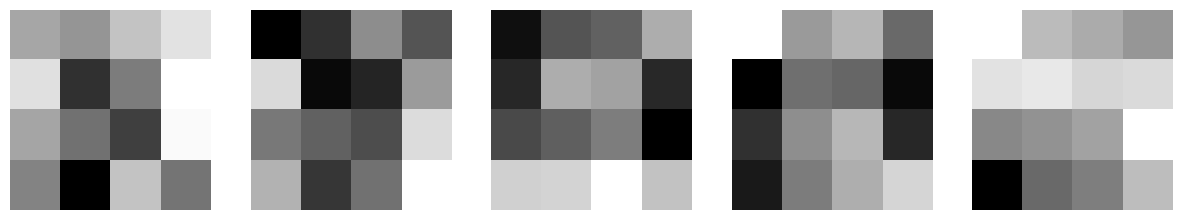

In [34]:
# @title analysis: CNN kernels

fig, axs = plt.subplots(1, channels, figsize=(3*channels, 3))

for i in range(1):
    for j in range(channels):
        axs[j].imshow(model.cnn[0].weight[i*channels+j].detach().cpu().numpy().squeeze(), cmap='gray')
        axs[j].axis('off')

plt.show()

[1.4642618 1.9988058 1.9181385 2.0981493 2.5206447]


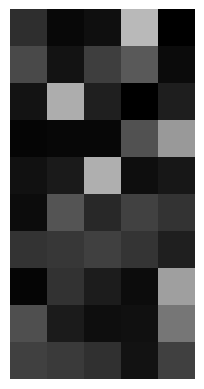

In [35]:
# @title analysis: convex

matrix = nn.functional.softmax(model.merge._weights[0,:,0,:], dim=-1).detach().cpu().numpy()

plt.imshow(matrix, cmap='gray', vmin=0, vmax=1)
plt.axis('off')

# peso dei canali
print(matrix.sum(axis=0))

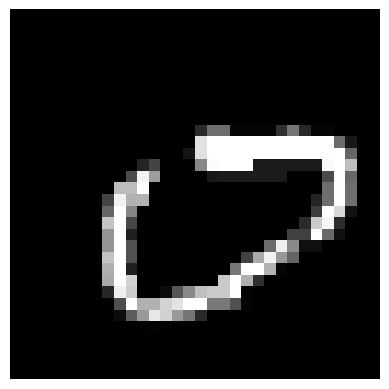

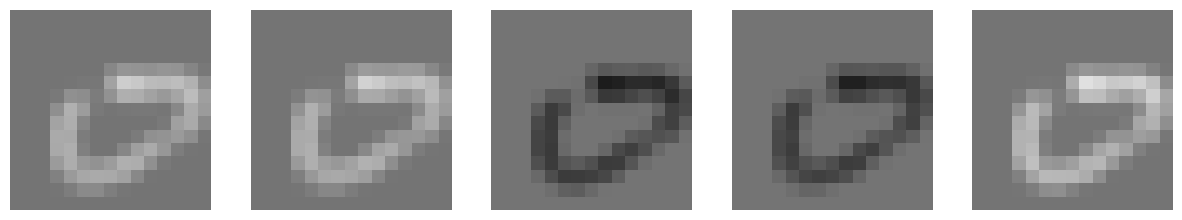

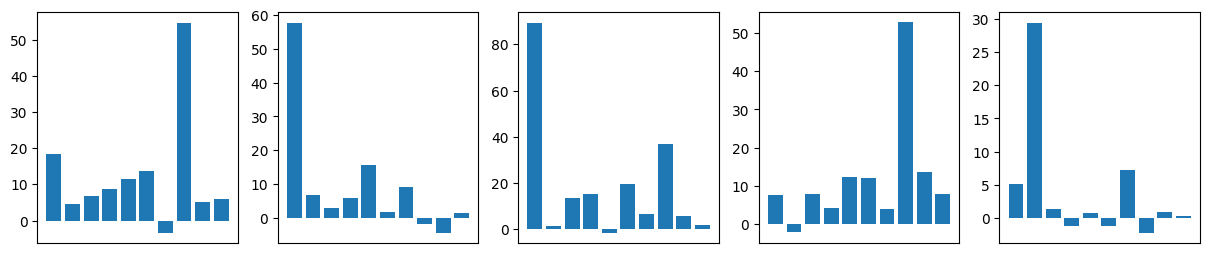

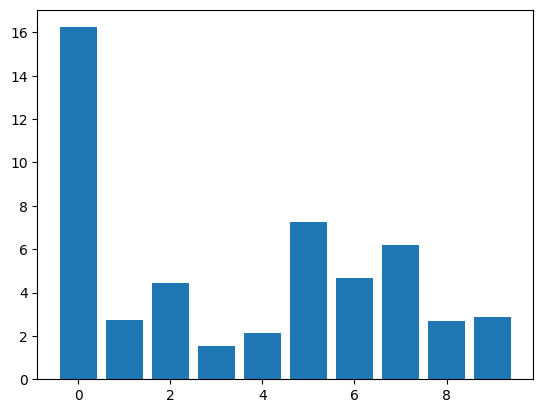

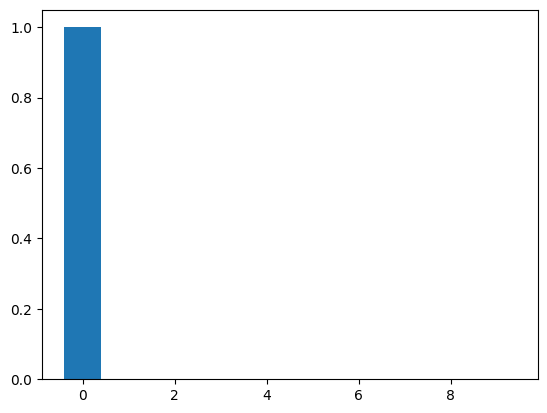

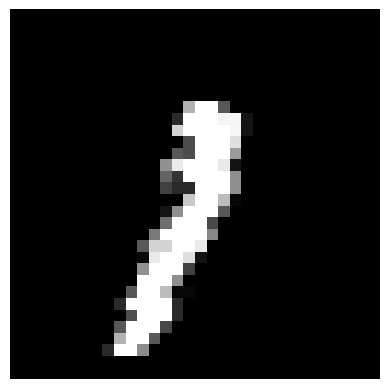

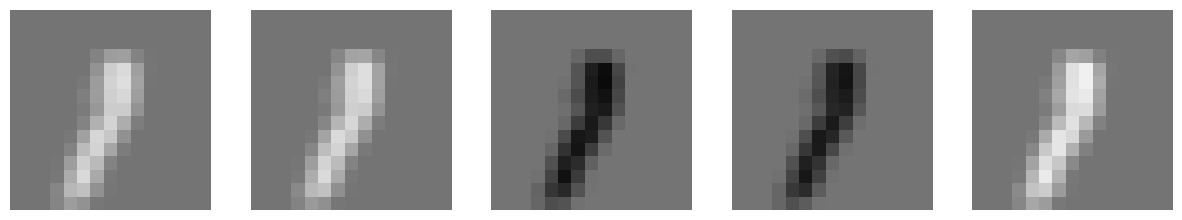

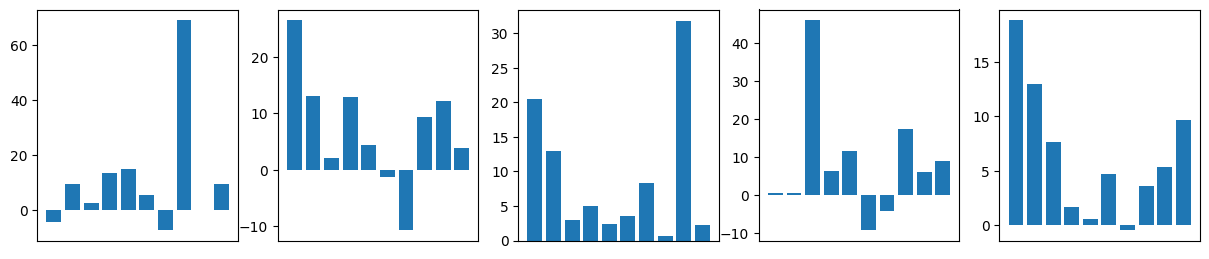

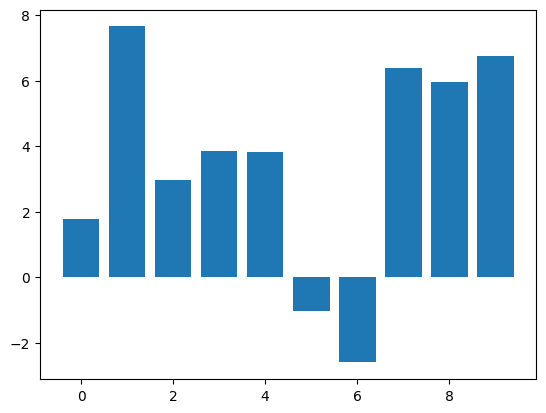

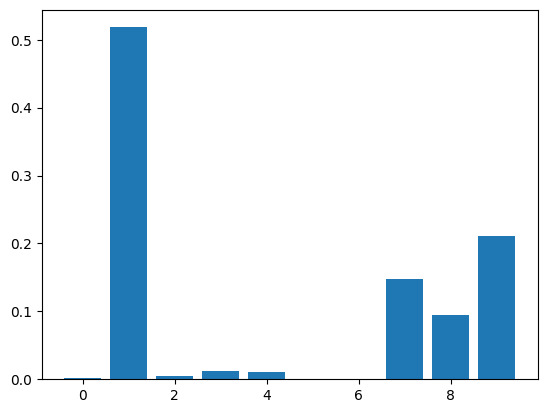

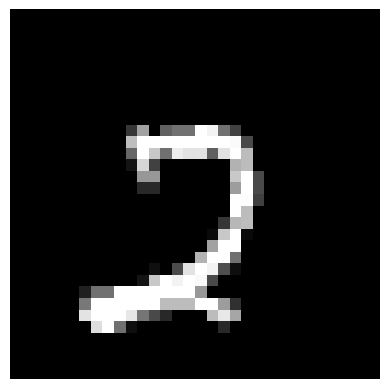

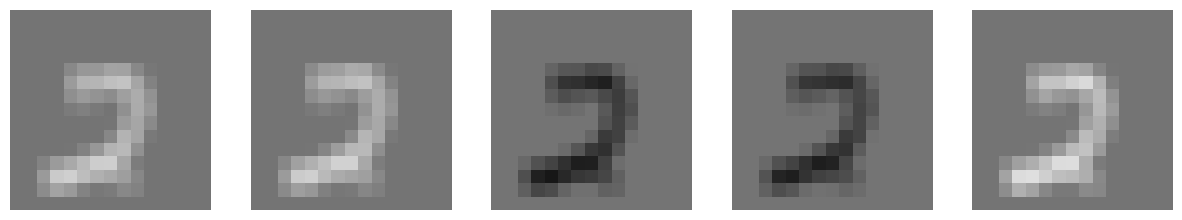

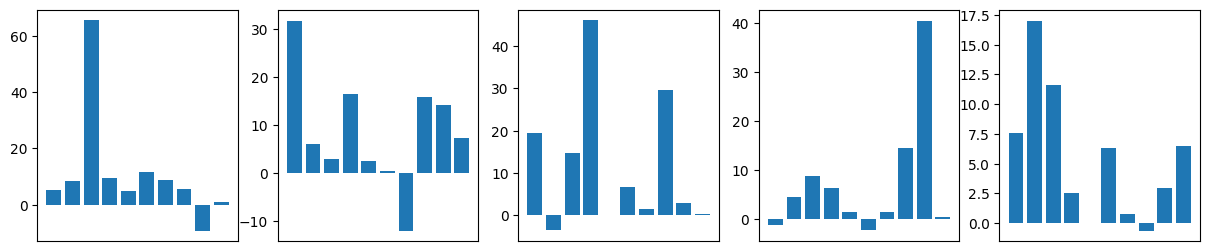

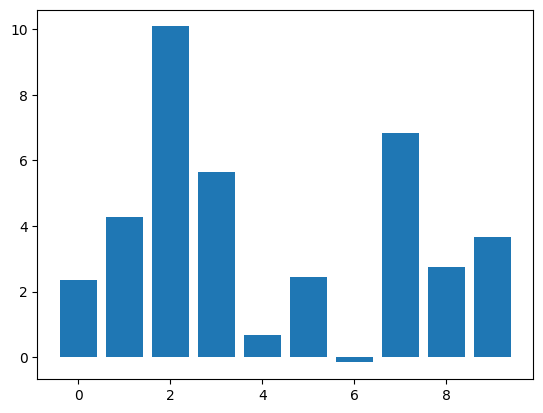

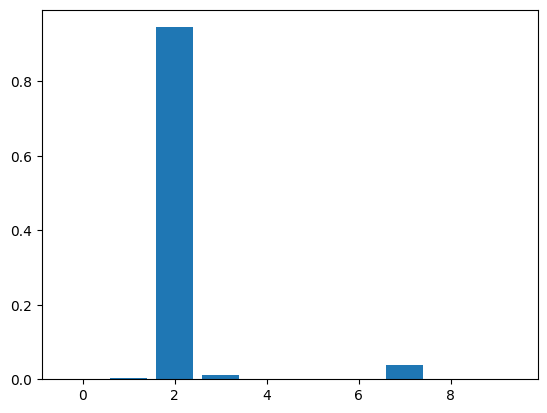

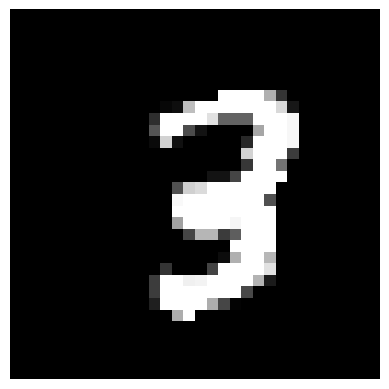

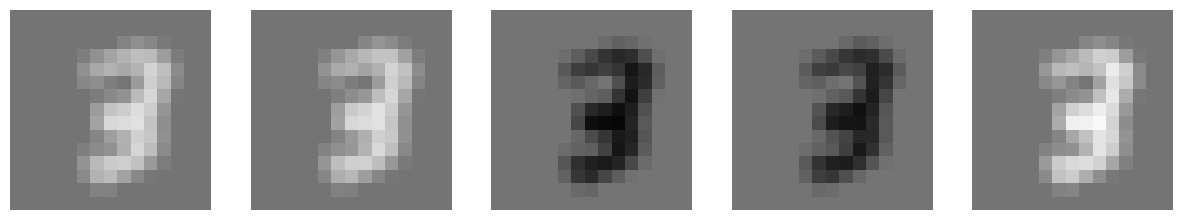

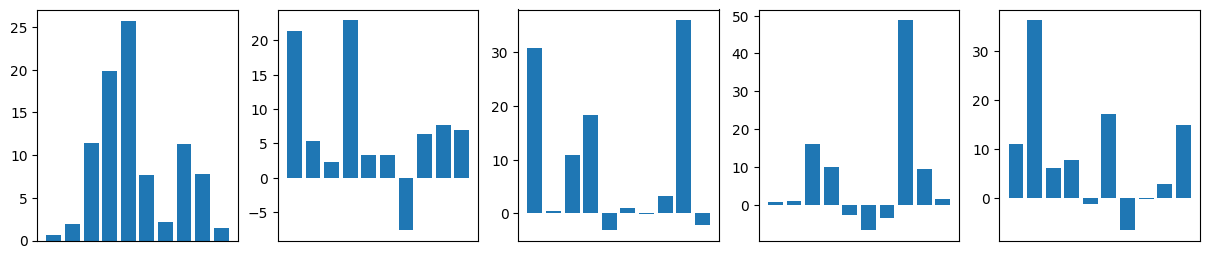

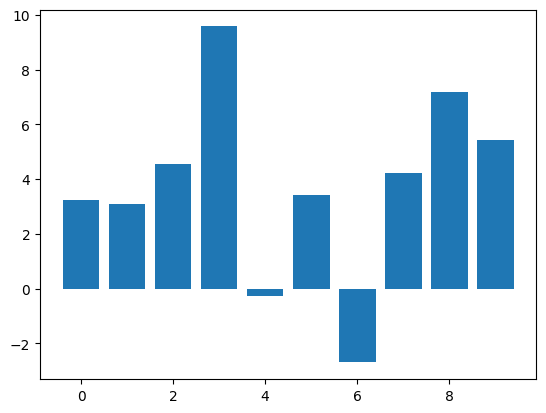

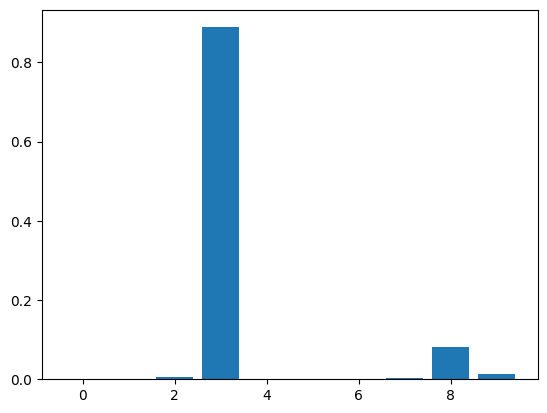

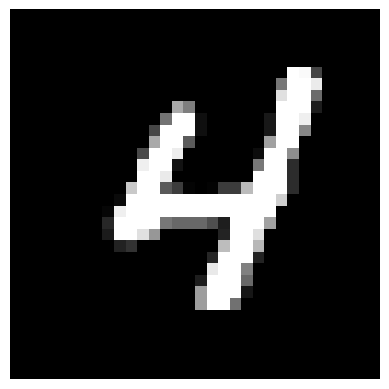

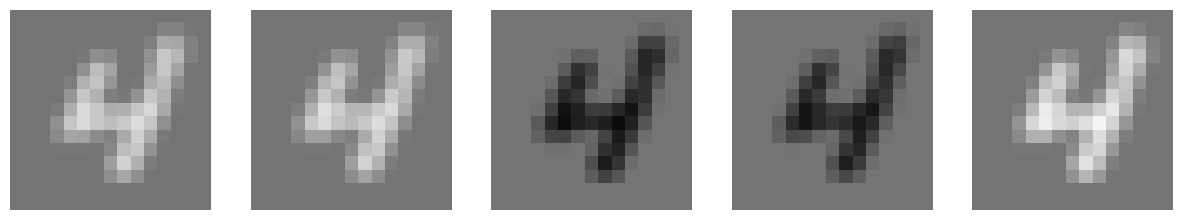

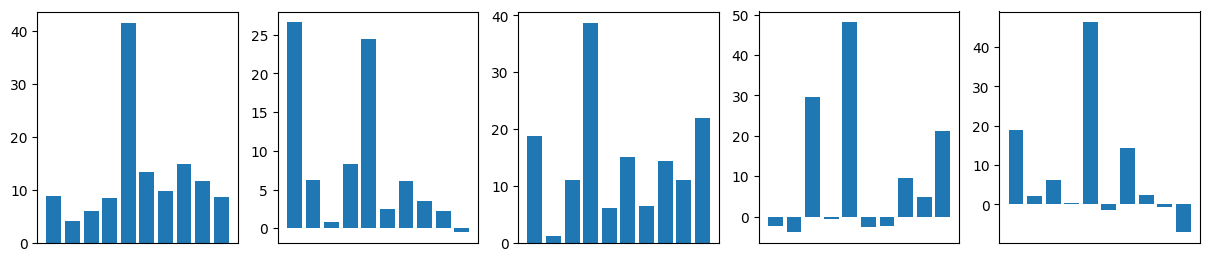

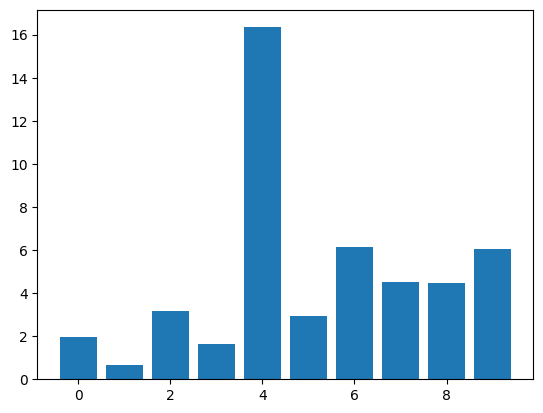

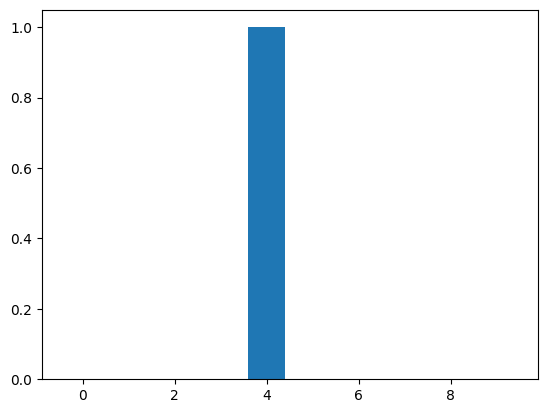

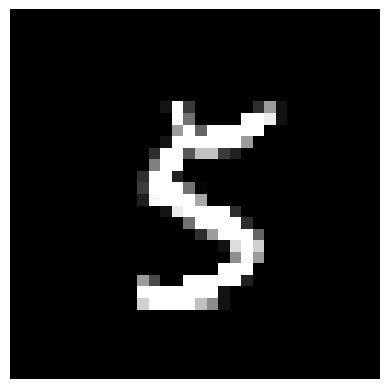

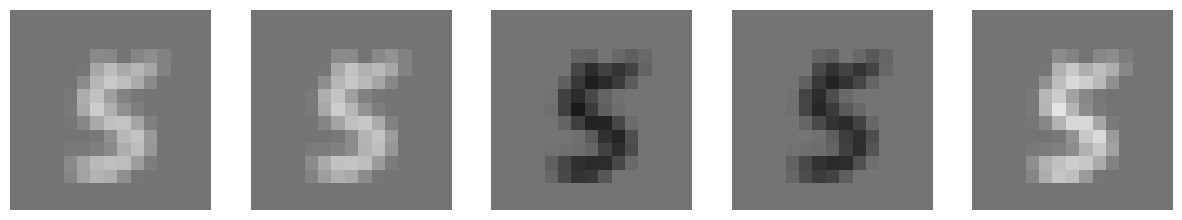

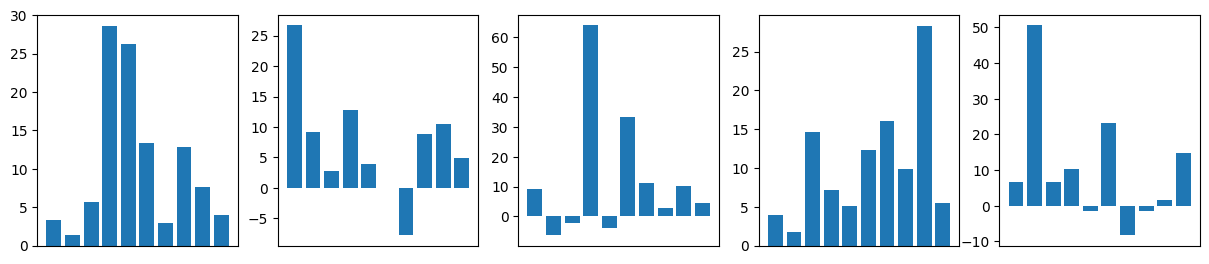

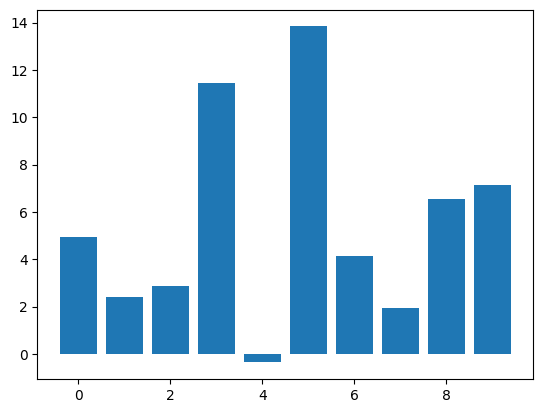

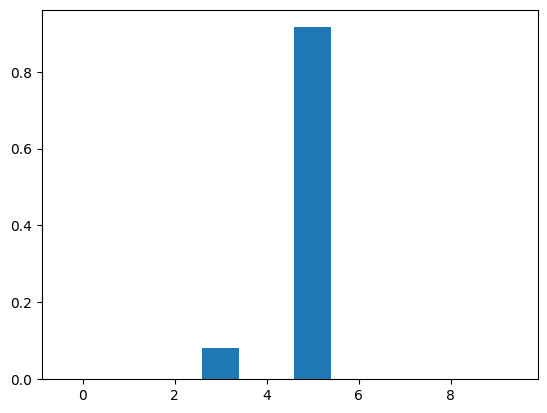

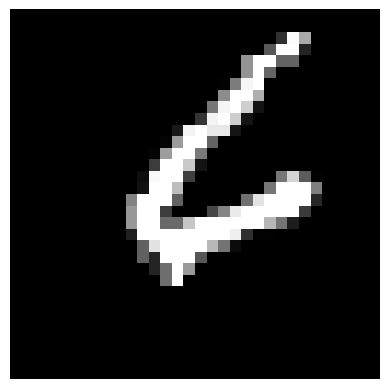

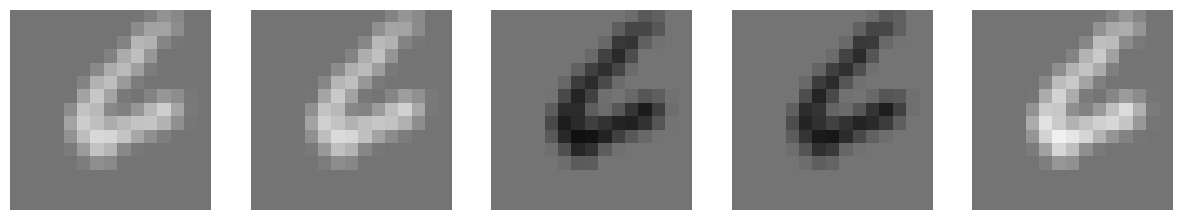

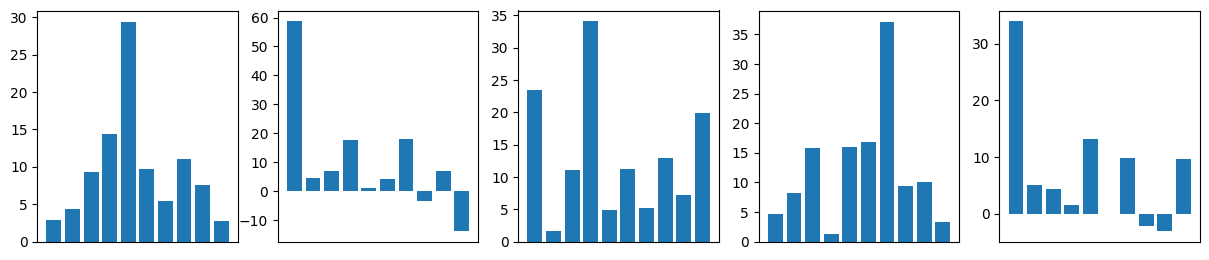

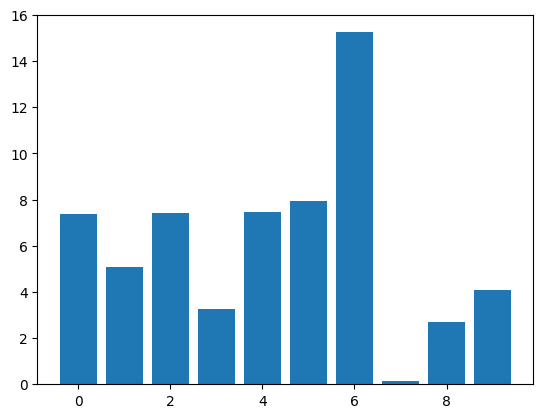

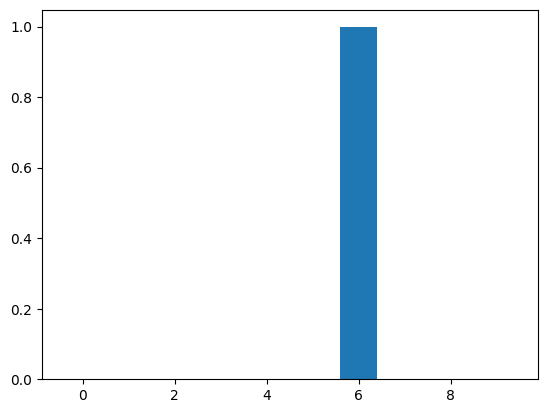

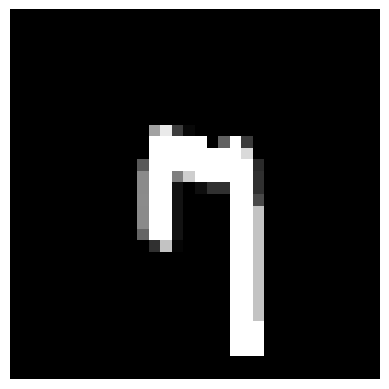

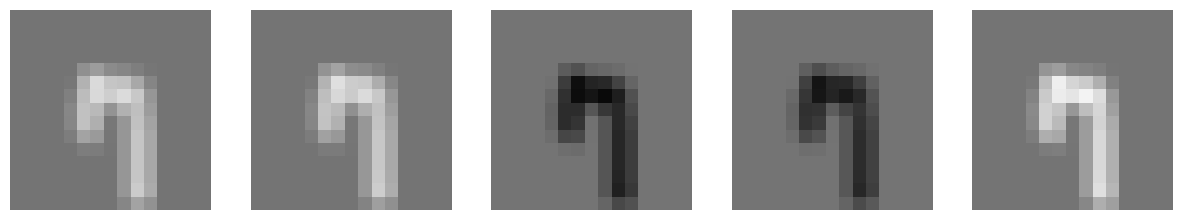

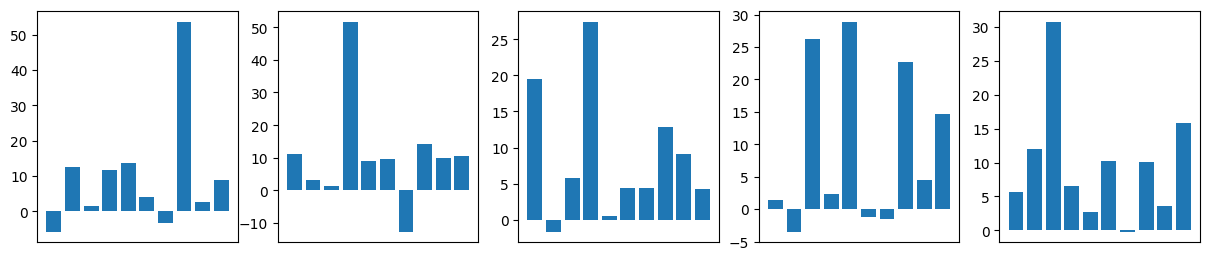

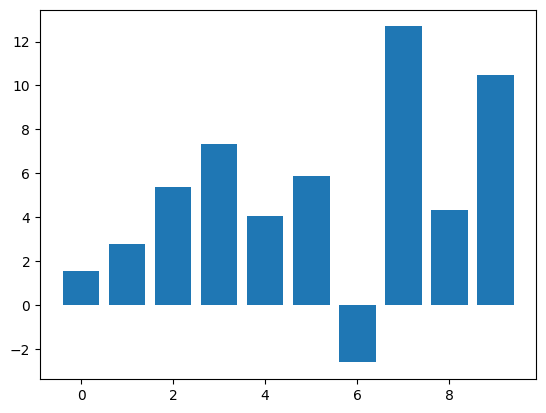

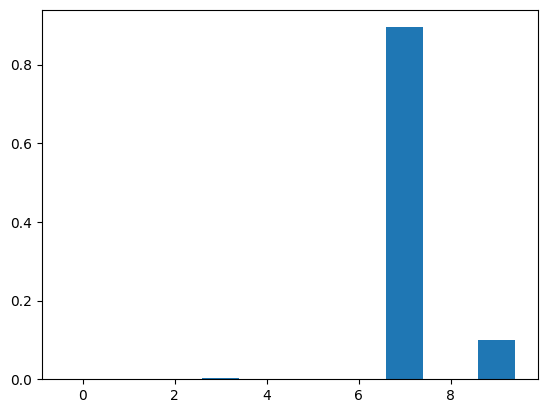

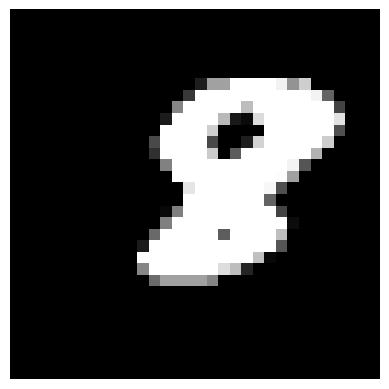

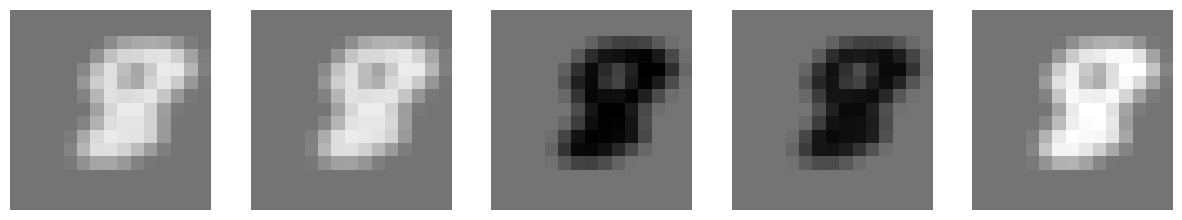

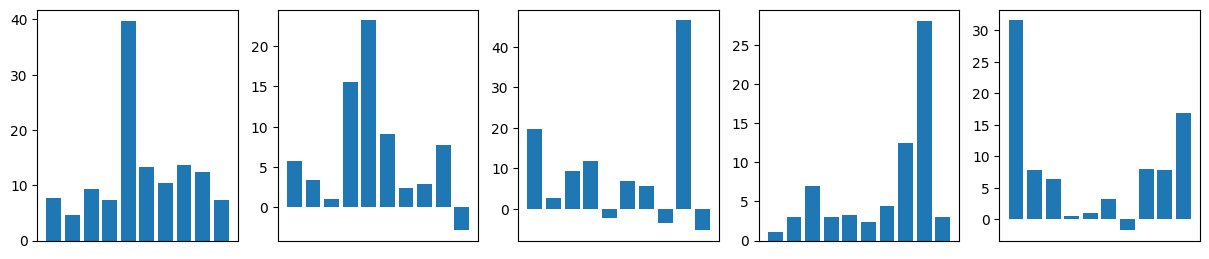

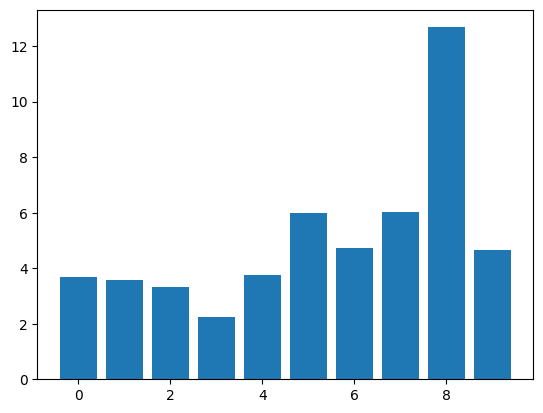

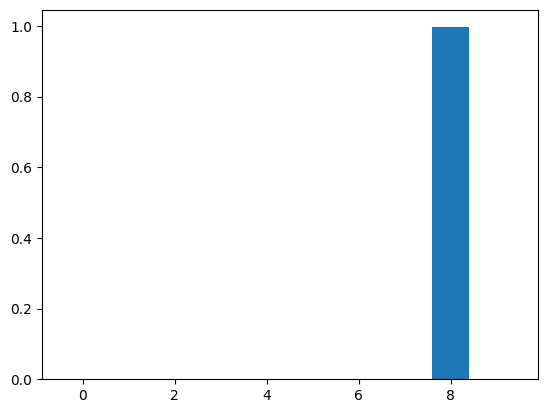

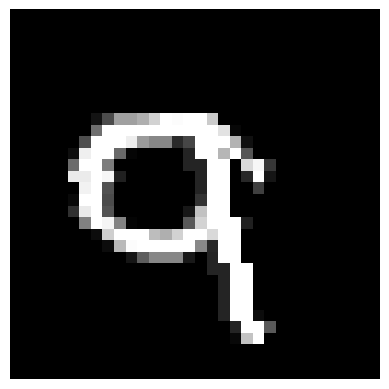

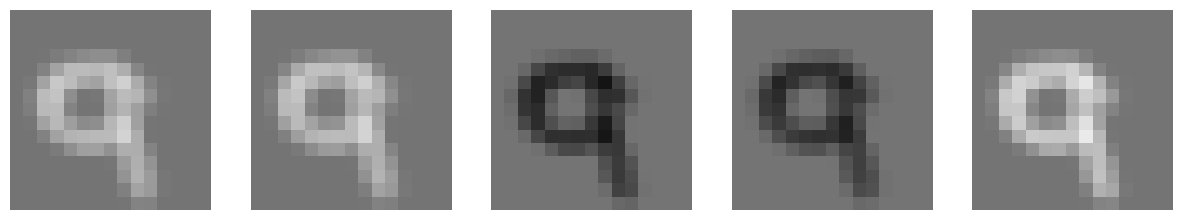

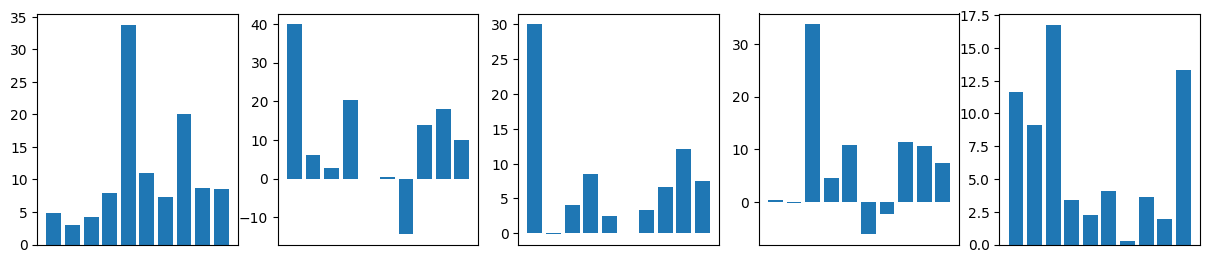

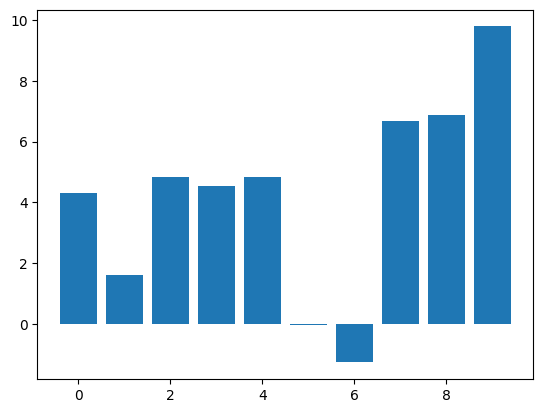

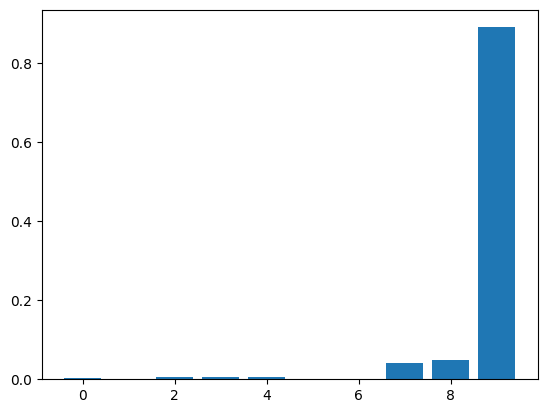

In [36]:
# @title an example

test_set = datasets.MNIST(mnist_contents, train=False, download=False, transform=transform)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=True)

# variables
for digit in range(10):

    # get an image with digit 7
    x, y = next(iter(test_loader))
    x = x[y == digit].to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    y = y[y == digit].to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    plt.imshow(x[0,0].view(32, 32).detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()

    x = model.cnn(x)
    fig, axs = plt.subplots(1, channels, figsize=(3*channels, 3))
    for i in range(channels):
        axs[i].imshow(x[0,i].view(15, 15).detach().cpu().numpy(), cmap='gray', vmin=x.min(), vmax=x.max())
        axs[i].axis('off')
    plt.show()

    x = x.view(-1, channels, 15*15)
    x = model.Hopfield(x).view(-1, channels, features)
    fig, axs = plt.subplots(1, channels, figsize=(3*channels, 3))
    for i in range(channels):
        axs[i].bar(range(features), x[0,i,:].detach().cpu().numpy())
        axs[i].get_xaxis().set_visible(False)
    plt.show()

    x = x.transpose(1, 2).view(-1, 1, features, channels)  # 10x4
    x = model.merge(x)
    x = x.view(-1, features)

    plt.bar(range(features), x[0].detach().cpu().numpy())
    plt.show()
    plt.bar(range(features), nn.functional.softmax(x[0], dim=0).detach().cpu().numpy())
    plt.show()

## Hopfield as CNN

trainable parameters: 733


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

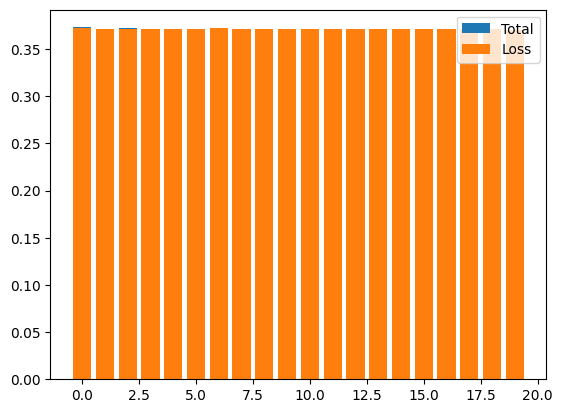

In [ ]:
# @title training
train_set = datasets.MNIST(mnist_contents, train=True, download=False, transform=transform)
train_loader = data.DataLoader(train_set, batch_size=512, shuffle=True)

class MyModel(nn.Module):

    def __init__(self):
        super(MyModel, self).__init__()
        self.hopfield = ConvHNN2d(1, 9, (5,5), iterations=2)
        self.LAE = nn.Sequential(
            nn.SiLU(),
            nn.Conv2d(9, 3, (3,3), padding=(2,2)),
            nn.SiLU(),
            nn.ConvTranspose2d(3, 9, (3,3), padding=(2,2)),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = functional.pad(x, (4, 4, 4, 4), value=-1)
        x = self.hopfield(x)
        
        x = self.LAE(x)

        # rebuild image
        x = nn.functional.softmax(x, dim=1)
        x = nn.functional.conv_transpose2d(x,weight=self.hopfield._patterns)

        # last adjustment
        x = torch.clamp(x, -1, 1)
        x = x[:, :, 4:36, 4:36]

        return x

model = MyModel()

print(f"trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

loss_fn = nn.MSELoss()

def reg_fn(model: MyModel) -> torch.Tensor:
    reg = torch.tensor(0.0).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    reg += torch.mean(torch.abs(model.LAE[1].weight))
    reg += torch.mean(torch.abs(model.LAE[3].weight))
    return 0.01 * reg

def input_converter(x: torch.Tensor) -> torch.Tensor:
    x = x + torch.randn_like(x, device=x.device)*0.5  # final noise 1.0
    x = x*2 - 1
    return x

def output_converter(y: torch.Tensor) -> torch.Tensor:
    y = y*2 - 1
    return y

loss : List[float] = []
reg : List[float] = []
total : List[float] = []

optimizer = optim.Adam(model.parameters(), lr=0.01)
l, r, t = trainer_autoencoder(
    model,
    train_loader,
    loss_fn,
    reg_fn,
    optimizer,
    20,
    input_converter=input_converter,
    output_converter=output_converter,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)
loss += l
reg += r
total += t

# show graph with evolution of loss and reg
plt.bar(range(len(total)), total, label="Total")
plt.bar(range(len(loss)), loss, label="Loss")
plt.legend()
plt.show()

In [38]:
# @title testing
test_set = datasets.MNIST(mnist_contents, train=False, download=False, transform=transform)
test_loader = data.DataLoader(test_set, batch_size=2_048, shuffle=True)

tester_autoencoder(model, test_loader, torch.device("cuda" if torch.cuda.is_available() else "cpu"), input_converter=input_converter, output_converter=output_converter)

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

0.3761666834354401

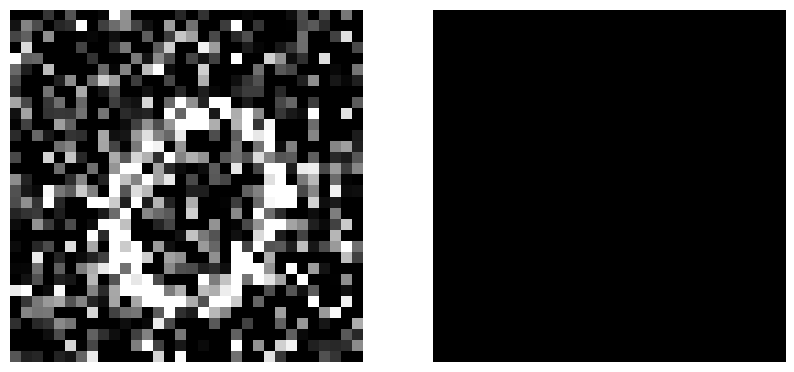

In [39]:
# @title example
model.to('cpu')
img = next(iter(test_loader))[0][0].to('cpu')
img = img.unsqueeze(0)
img = input_converter(img)
_y = model(img)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img[0,0].detach().cpu().numpy(), cmap='gray', vmin=-1, vmax=1)
axs[0].axis('off')
axs[1].imshow(_y[0,0].detach().cpu().numpy(), cmap='gray', vmin=-1, vmax=1)
axs[1].axis('off')
plt.show()

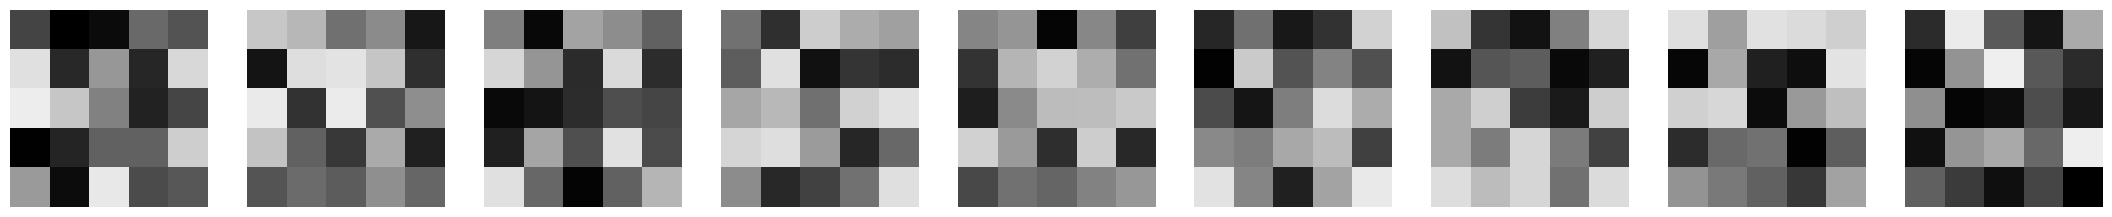

beta: tensor([0.3496])
bias: tensor([ 0.5460, -0.7585, -0.1732,  1.0356,  0.3735, -2.1714,  0.4797,  0.5828,
         1.1504])


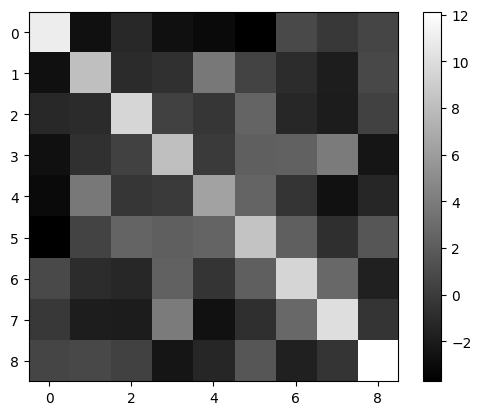

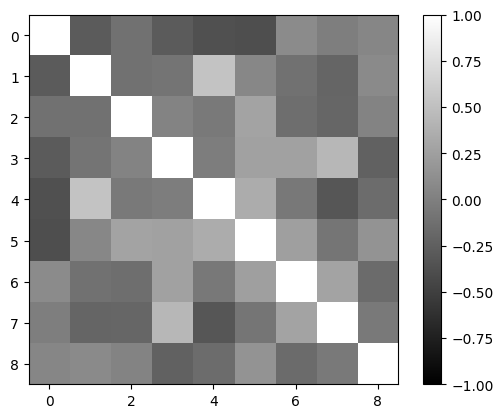

In [40]:
# @title analysis of the patterns for each convolution

model.to(torch.device("cpu"))

# first convolution
patterns = model.hopfield._patterns.data.view(9, 1, 5, 5).clone().numpy()
fig, axs = plt.subplots(1, 9, figsize=(9*3, 1*3))
p_max = patterns.max()
p_min = patterns.min()
r = max(abs(p_max), abs(p_min))
for i in range(9):
    axs[i].imshow(patterns[i,0], cmap='gray', vmin=-r, vmax=r)
    axs[i].axis('off')
plt.show()

print(f"beta: {torch.exp(model.hopfield._logbeta.data)}")
print(f"bias: {model.hopfield._bias.data}")

# pattern's separation
patterns = torch.tensor(patterns).view(9,-1)
matrix = torch.einsum('ic, jc -> ij', patterns, patterns)
plt.imshow(matrix.numpy(), cmap='gray')
plt.colorbar()
plt.show()

matrix = torch.einsum('ic, jc -> ij', patterns/torch.norm(patterns, dim=1)[:,None], patterns/torch.norm(patterns, dim=1)[:,None])
plt.imshow(matrix.numpy(), cmap='gray', vmin=-1, vmax=1)
plt.colorbar()
plt.show()


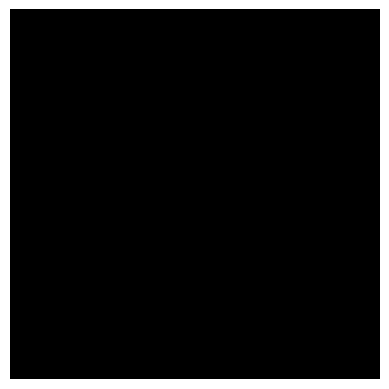

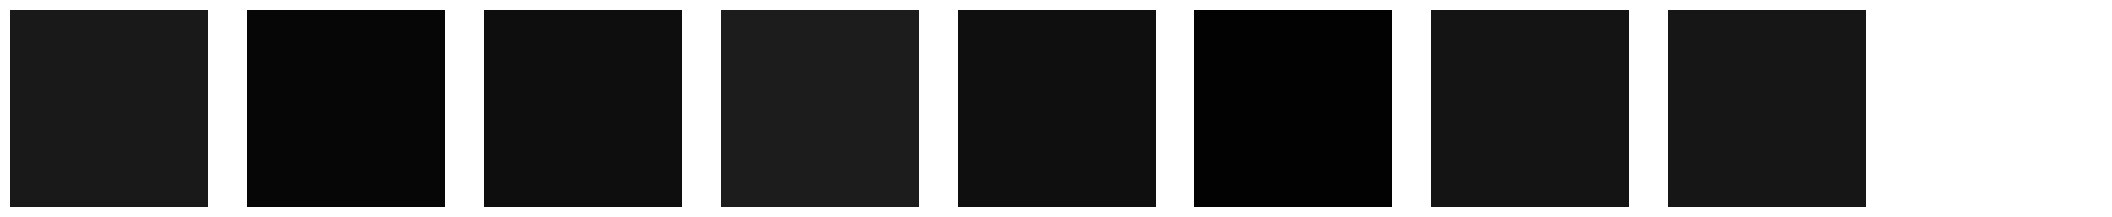

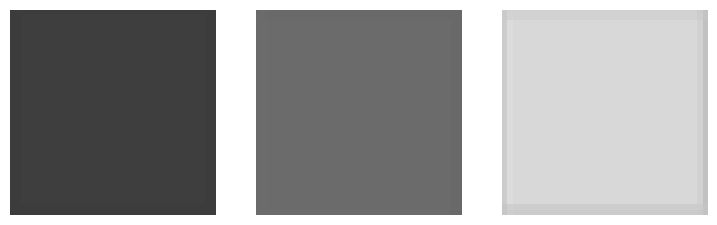

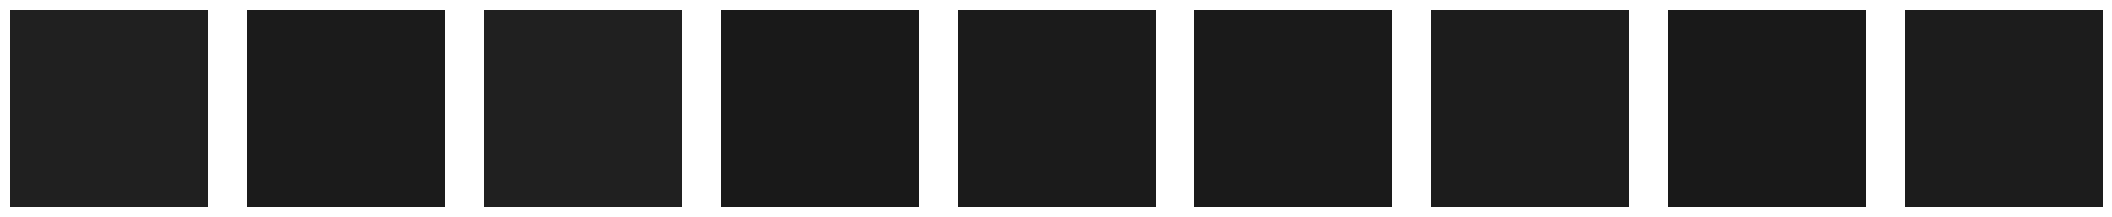

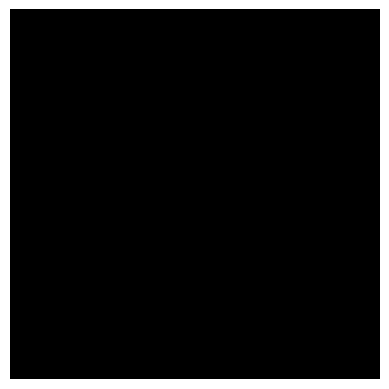

In [ ]:
# @title evolution of an image through the network
img = next(iter(test_loader))[0]
img = input_converter(img)
img = torch.zeros_like(img)-1

plt.imshow(img[0,0,:,:].to('cpu').numpy(), cmap='gray', vmin=-1, vmax=1)
plt.axis('off')
plt.savefig(f"{out_path}/MNIST_CNN_image.png", dpi=300)
plt.show()

x = img.clone()

# filter
x = functional.pad(x, (4, 4, 4, 4), value=-1)
x = model.hopfield(x)
y = nn.functional.softmax(x, dim=1)
fig, axs = plt.subplots(1, 9, figsize=(9*3, 1*3))
for j in range(9):
    axs[j].imshow(y.view(-1,1,9,36,36)[0,0,j].detach().to('cpu').numpy(), cmap='gray', vmin=0, vmax=y.max())
    axs[j].axis('off')
fig.savefig(f"{out_path}/MNIST_CNN_image1.png", dpi=300)
plt.show()

# LAE
x = model.LAE[0](x)
x = model.LAE[1](x)  # latent code
y = x.clone()
fig, axs = plt.subplots(1, 3, figsize=(3*3, 1*3))
for j in range(3):
    axs[j].imshow(y.view(-1,1,3,38,38)[0,0,j].detach().to('cpu').numpy(), cmap='gray', vmin=y.mean()-2*y.std(), vmax=y.mean()+2*y.std())
    axs[j].axis('off')
fig.savefig(f"{out_path}/MNIST_CNN_image2.png", dpi=300)
plt.show()
x = model.LAE[2](x)
x = model.LAE[3](x)
y = functional.softmax(x, dim=1)
fig, axs = plt.subplots(1, 9, figsize=(9*3, 1*3))
for j in range(9):
    axs[j].imshow(y.view(-1,1,9,36,36)[0,0,j].detach().to('cpu').numpy(), cmap='gray', vmin=0, vmax=1)
    axs[j].axis('off')
fig.savefig(f"{out_path}/MNIST_CNN_image3.png", dpi=300)
plt.show()

# ending
x = nn.functional.softmax(x, dim=1)
x = nn.functional.conv_transpose2d(
    x,
    weight=model.hopfield._patterns,
    stride=model.hopfield.stride,
    padding=model.hopfield.padding,
    dilation=model.hopfield.dilation,
)

x = torch.clamp(x, -1, 1)
x = x[:, :, 4:36, 4:36]

plt.imshow(x[0,0].detach().to('cpu').numpy(), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.savefig(f"{out_path}/MNIST_CNN_image4.png", dpi=300)
plt.show()

## Hopfield as VAE

In [47]:
# @title analyze patterns

patterns = patterns.view(1, 30, 32*32)

# compute M
M = torch.norm(patterns, dim=2).max(dim=1).values
print(f'{M=}')

# compute Delta_i
prod = torch.einsum('cin, cjn -> cij', patterns, patterns)
diag = prod.diagonal(dim1=1, dim2=2)
prod = diag.unsqueeze(2) - prod
max_prod = prod.max(dim=2).values
prod = prod + torch.diag_embed(max_prod)
Delta = prod.min(dim=2).values

print(f'{Delta=}')

# compute min Delta
Delta_min = Delta.min(dim=1).values

# compute a value
N = patterns.shape[1]
a = 2/N + torch.log(2*N*(N-1)*M**2/Delta_min)
if a.min() > 1:
    num_of_iterations = 5
    def f(x):
        return a+torch.log(x)
    x0 = 2*a.clone()
    for _ in range(num_of_iterations):
        x0 = f(x0)
    beta_p = x0
    x0 = (7*torch.ones_like(a) + x0)/8
    beta = x0 / Delta_min
else:
    print(a)
    raise ValueError("a must be greater than 1")

# compute S radius
S_radius = 1 / (beta*N*M)
print(f'{beta=}')
print(f'{S_radius=}')

M=tensor([31.3933])
Delta=tensor([[ 88.0986,  80.1672, 131.7368,  53.4877,  69.0222,  59.4534,  63.2126,
          63.9695,  69.7267,  65.0894,  55.4366,  46.0532,  66.9539,  62.2354,
          46.1037,  41.8603,  39.9262,  37.5255,  45.8450,  60.8577,  49.2501,
          55.7401,  51.3837,  35.1906,  52.2477,  56.2899,  69.4982, 107.1295,
          74.5176,  51.1973]])
beta=tensor([0.0727])
S_radius=tensor([0.0146])


In [48]:
# @title create initial status

xi = torch.mean(patterns, dim=1).view(1, 1, 32*32) + torch.randn(5, 1, 32*32) * 10.0
dist = (torch.einsum('bcn, cpn -> bcp', xi, patterns))**0.5
dist_min = dist.min(dim=-1).values
if (dist_min <= S_radius.view(1, -1)).any():
    raise ValueError("dist_min must be greater than S_radius")
print(dist_min/32)

tensor([[0.8207],
        [0.7709],
        [0.9949],
        [0.9407],
        [1.1403]])


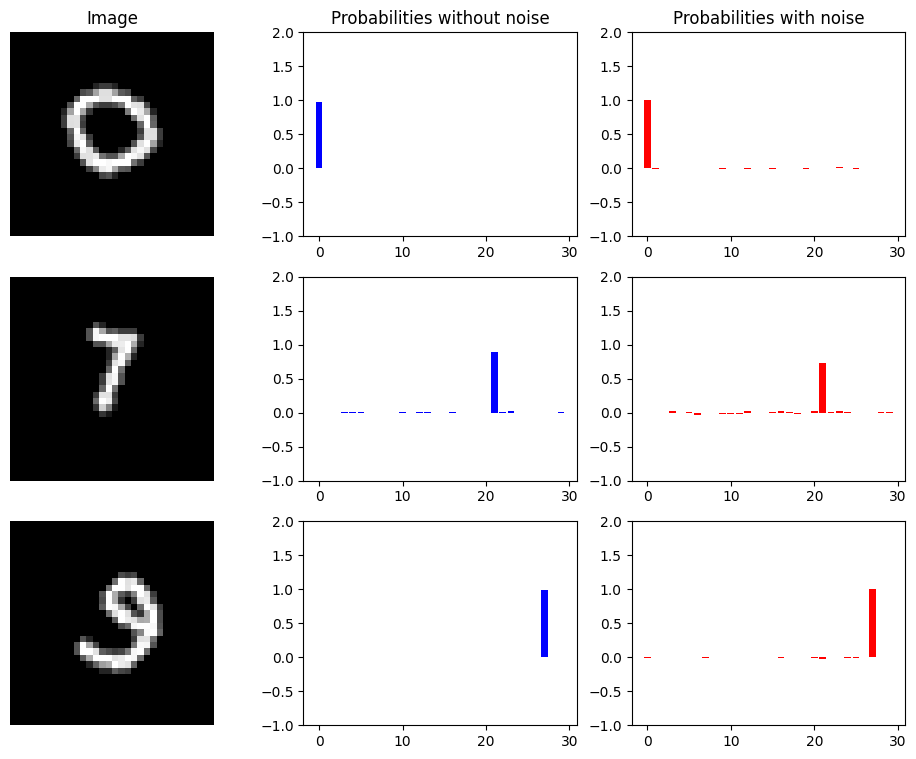

In [49]:
# @title create a VHNN

xi = patterns[:, [0,21,27], :].clone().detach()

model = VHNN(1, 30, 32*32, beta_trainable=False, patterns_trainable=False, noise_trainable=False)
model.update_patterns(patterns)
model.update_beta(torch.ones_like(beta)*0.063)
model.update_noise(torch.tensor([0.3]))

x = xi.clone()
x = x.view(xi.shape[1], 1, -1)

# make frames for the animation
frames = 1000
states_image = torch.zeros(frames, xi.shape[1], 1, 32*32)
nonoise_probs = torch.zeros(frames, xi.shape[1], 30)
noise_probs = torch.zeros(frames, xi.shape[1], 30)
L = torch.exp(model._logbeta/2).view(-1, 1, 1) * model._patterns
x = torch.exp(model._logbeta/2).view(-1, 1, 1) * x
for i in range(frames):
    states_image[i,:,0,:] = x.view(xi.shape[1], 32*32)
    x = torch.einsum('cfn, bcn -> bcf', L, x)
    x = nn.functional.softmax(x, dim=2)
    nonoise_probs[i,:,:] = x.view(xi.shape[1],30)
    epsilon = torch.randn_like(x, device=x.device)
    x = x + torch.exp(model._lognoise) * (x*(1-x))**0.5 * epsilon
    noise_probs[i,:,:] = x.view(xi.shape[1],30)
    x = torch.einsum('cfn, bcf -> bcn', L, x)
x = torch.exp(-model._logbeta/2).view(1, -1, 1) * x

# make the animation
reduction_factor = 8
states_image = states_image[::reduction_factor]
nonoise_probs = nonoise_probs[::reduction_factor]
noise_probs = noise_probs[::reduction_factor]
frames = frames // reduction_factor

fig, axs = plt.subplots(xi.shape[1], 3, figsize=(4*3, 3*xi.shape[1]))
axs[0,0].set_title("Image")
axs[0,1].set_title("Probabilities without noise")
axs[0,2].set_title("Probabilities with noise")
for i in range(xi.shape[1]):
    axs[i,0].axis('off')
    axs[i,1].set_ylim(-1, 2)
    axs[i,2].set_ylim(-1, 2)
def update(frame):
    for i in range(xi.shape[1]):
        axs[i,0].clear()
        axs[i,1].clear()
        axs[i,2].clear()
    axs[0,0].set_title("Image")
    axs[0,1].set_title("Probabilities without noise")
    axs[0,2].set_title("Probabilities with noise")
    for i in range(xi.shape[1]):
        axs[i,0].axis('off')
        axs[i,1].set_ylim(-1, 2)
        axs[i,2].set_ylim(-1, 2)
    for i in range(xi.shape[1]):
        axs[i,0].imshow(states_image[frame,i].view(32, 32).detach().numpy(), cmap='gray')
        axs[i,1].bar(range(30), nonoise_probs[frame,i].detach().numpy(), color='blue')
        axs[i,2].bar(range(30), noise_probs[frame,i].detach().numpy(), color='red')
    return axs

ani = animation.FuncAnimation(fig, update, frames=frames, blit=False)
ani.save(f"{out_path}/VHNN_MNIST_animation.gif", writer='pillow', fps=24)